In [1]:
import os
import sys
import time
import copy
import glob
import shap
import pickle
import random
import string
import joblib
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from joblib import load
from scipy import stats
from matplotlib import cm
import statsmodels.api as sm
from keras.models import Model
from scipy.stats import zscore
from collections import Counter
from scipy.stats import entropy
from ipywidgets import interact
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp
import matplotlib.lines as mlines
import plotly.graph_objects as go
from sklearn.cluster import DBSCAN
from keras.models import load_model
import matplotlib.colors as mcolors
from sklearn.metrics import r2_score
from scipy.stats import kstest, norm
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import pearsonr, spearmanr
from sklearn.ensemble import IsolationForest
from tensorflow.keras.models import load_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import median_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PowerTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.cross_decomposition import CCA, PLSRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score
  

def plot_distributions(network_input, network_output, ground_truth, sample_idx):
    plt.figure(figsize=(12, 4))
    sns.histplot(network_input[sample_idx].flatten(), color="skyblue", label="Input", kde=True)
    sns.histplot(network_output[sample_idx].flatten(), color="red", label="Output", kde=True)
    sns.histplot(ground_truth[sample_idx].flatten(), color="green", label="Ground Truth", kde=True)
    plt.legend()
    plt.title(f'Distribution Comparison for Sample {sample_idx}')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.show()
    

def error_distribution_analysis(network_output, ground_truth):
    errors = network_output - ground_truth
    sns.histplot(errors.flatten(), kde=True, color="red")
    plt.title('Overall Error Distribution')
    plt.xlabel('Error')
    plt.ylabel('Frequency')
    plt.show()  
    

def calculate_samplewise_mae(network_output, ground_truth):
    return np.mean(np.abs(network_output - ground_truth), axis=(1, 2))


def plot_error_vs_all_parameters(df, network_output, ground_truth):
    sample_mae = calculate_samplewise_mae(network_output, ground_truth)
    df['Error'] = sample_mae
    parameters = ['planet_radius', 'planet_mass', 'co_ratio', 'isothermal_T', 'metalicity']
    plt.figure(figsize=(15, 10))
    for i, param in enumerate(parameters, 1):
        plt.subplot(2, 3, i)
        sns.scatterplot(x=df[param], y=df['Error'])
        plt.xlabel(param)
        plt.ylabel('Error')
        plt.title(f'Error vs. {param}')
    plt.tight_layout()
    plt.show()


def preprocessing_function(log_data, params=None):
    log_data = np.clip(log_data, a_min=-20, a_max=None)
    min_value = -20
    max_value = 0
    min_max_scaled_data = (log_data - min_value) / (max_value - min_value) * 2 - 1
    min_max_scaled_data = np.nan_to_num(min_max_scaled_data, 0)
    return min_max_scaled_data


def data_norm(name, output = False,network = False, save_idx=None):
    """Load one data example and use log transform
    Return array of size (Layers, Molecules, 1)"""
    arr = load_array_3d(name) # arr shape is (100,111) or (layers, molecules)
    #if chexanet:
      #  Nlayers = 96
    #else:
    Nlayers = 96
    if network:
        arr = arr.reshape((64,Nlayers))
        return arr
    if output :
        arr = arr[-1]
    if save_idx is not None:
        arr = arr[save_idx,:]
 
    arr = np.log10(arr)[:,:Nlayers]  # logarithm 
    
    arr = preprocessing_function(arr) 
    return arr


def load_data(data_dir, output=False,network = False, save_idx=None):
    """Load all data (Train/Test) and apply log transform
    Return it as np array of size (number_of_examples, Layers, Molecules,1)"""
    data_list = np.sort(glob.glob(f'{data_dir}/*npy'))
    array = []
    _ = [array.append(data_norm(name, output=output,network=network, save_idx=save_idx)) for name in data_list]
    array = np.array(array)
    return array, data_list


def create_dict(names):
    molecule_dict = {}
    for name in names:
        molecule_dict[name] = []
    return molecule_dict


def load_array_3d(filename):
    with open(filename, 'rb') as f:
        arr = np.load(f)
    return arr


def inverse_preprocessing(scaled_data):
    min_value = -20
    max_value = 0
    log_data = ((scaled_data + 1) / 2) * (max_value - min_value) + min_value
    return log_data


def calculate_correlations(df, network_output, ground_truth):
    sample_mae = calculate_samplewise_mae(network_output, ground_truth)
    df['Error'] = sample_mae
    parameters = ['planet_radius', 'planet_mass', 'co_ratio', 'isothermal_T', 'metalicity']
    for param in parameters:
        pearson_corr, _ = pearsonr(df[param], df['Error'])
        spearman_corr, _ = spearmanr(df[param], df['Error'])
        print(f"{param} - Pearson correlation with error: {pearson_corr:.3f}")
        print(f"{param} - Spearman correlation with error: {spearman_corr:.3f}")


def tidy_values(x):
    if x == 0:
        return 0
    elif abs(x) < 0.001:
        return format(x, '.2e')  # Scientific notation for small numbers
    else:
        return round(x, 5)  # Round to 5 significant digits for larger numbers


def convert_pascals_to_bars(pascals):
        """Convert a list of values from Pascals to Bars."""
        return [pascal * 1e-5 for pascal in pascals]
    
    
    
def print_statistics(network_output, ground_truth, name):
    network_output_2d = network_output.reshape(network_output.shape[0], -1)
    ground_truth_2d = ground_truth.reshape(ground_truth.shape[0], -1)

    mae_per_atmosphere = np.mean(np.abs(ground_truth - network_output), axis=(1, 2))
    highest_mae = round(np.max(mae_per_atmosphere), 4)
    lowest_mae = round(np.min(mae_per_atmosphere), 4)
    
    mse_net =  round(mean_squared_error(ground_truth_2d, network_output_2d),5)
    mae_net =  round(mean_absolute_error(ground_truth_2d, network_output_2d),4)
    std_net= round(np.std(ground_truth_2d - network_output_2d),4)
    #kl_divs = calculate_kl_divergence(ground_truth_2d, network_output_2d) 
    print(f'Model {name} & {highest_mae} & {lowest_mae} & {mae_net} & {mse_net} & {std_net} \\\\')
    
    
def print_statistics_MAPE(network_output, ground_truth, name):
    epsilon = 1e-10
    mape_per_atmosphere = np.mean(np.abs((network_output - ground_truth) / (ground_truth + epsilon)), axis=(1, 2)) * 100

    
    num_samples_above_10_percent = np.sum(mape_per_atmosphere > 10)
    p_10 = round(100*num_samples_above_10_percent/len(mape_per_atmosphere),2) 
    num_samples_above_50_percent = np.sum(mape_per_atmosphere > 50)
    p_50 = round(100*num_samples_above_50_percent/len(mape_per_atmosphere),2)
    
    print(f'Model {name} & {num_samples_above_10_percent} & {p_10} & {num_samples_above_50_percent} & {p_50} \\\\')
    
    
    
def print_statistics_KL(network_output, ground_truth, name):
    kl_divs = [calculate_kl_divergence(ground_truth[i], network_output[i]) for i in range(len(ground_truth))]
    mean_kl_div_gt_to_network = round(np.mean(kl_divs), 7)
    highest_kl_div_gt_to_network = round(np.max(kl_divs), 7)
    lowest_kl_div_gt_to_network = round(np.min(kl_divs), 9)
    
    print(f'Model {name}  & {mean_kl_div_gt_to_network} & {highest_kl_div_gt_to_network} & {lowest_kl_div_gt_to_network} & \\\\')

In [ ]:
data_example = pd.read_csv(glob.glob(...)[0])
pressure = np.array(data_example['Pressure'].to_list())[:64]
data_example = data_example.drop(columns=['Altitude_m','Pressure'])

molecules = data_example.columns.to_list()
molecule_dict = create_dict(molecules)

save_molecules = np.array([ 34,  36,  39,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,
        51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,
        64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,
        77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  90,  91,
        94,  96,  97, 100, 101, 102, 104, 105, 106, 108, 109, 110])


path = ...
molecule_len = len(save_molecules)
molecules = list(np.array(molecules)[save_molecules])
network_output_dl16, data_list= load_data(..., save_idx=save_molecules, network=True)
network_output_dl8, data_list= load_data(..., save_idx=save_molecules, network=True)
network_output_att, data_list= load_data(..., save_idx=save_molecules, network=True)
network_output_att_addinf, data_list= load_data(..., save_idx=save_molecules, network=True)
network_output_simple, data_list= load_data(..., save_idx=save_molecules, network=True)

file_names = [path.split('/')[-1].split('.')[0] for path in data_list]
configuration = pd.read_csv(...)[:5148]
configuration = configuration[configuration['System_ID'].isin(file_names)]
configuration = configuration.sort_values(by='System_ID', key=lambda x:
                                                    x.map({name: i for i, name in enumerate(file_names)}))
configuration = configuration.reset_index(drop=True)
network_input, _= load_data(f'{path}input/', save_idx=save_molecules)

file_names = [path.split('/')[-1].split('.')[0] for path in data_list]


data_list_X = np.sort(glob.glob(...))
file_names = [path.split('/')[-1] for path in data_list_X]

co_ratio = np.array(configuration['co_ratio'].to_list())
planet_mass = np.array(configuration['planet_mass'].to_list())
planet_radius = np.array(configuration['planet_radius'].to_list())
temp = np.array(configuration['isothermal_T'].to_list())
metallicity = np.array(configuration['metalicity'].to_list())

ground_truth, data_list_gt= load_data(..., save_idx=save_molecules, output=True)
file_names_gt = [path.split('/')[-1].split('.')[0] for path in data_list_gt]

In [2]:
data_example = pd.read_csv(glob.glob('/Users/sponka/Desktop/taurex/taurex/data/mix_profiles/*csv')[0])
pressure_chexanet = np.array(data_example['Pressure'].to_list())[:96]
pressure = np.array(data_example['Pressure'].to_list())[:96]
pressure_full = np.array(data_example['Pressure'].to_list())
data_example = data_example.drop(columns=['Altitude_m','Pressure'])

molecules = data_example.columns.to_list()
molecule_dict = create_dict(molecules)

save_molecules = np.array([ 34,  36,  39,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,
        51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,
        64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,
        77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  90,  91,
        94,  96,  97, 100, 101, 102, 104, 105, 106, 108, 109, 110])


path = '/Users/sponka/Desktop/taurex/taurex/U-net/evaluation/test_data2/'
molecule_len = len(save_molecules)
molecules = list(np.array(molecules)[save_molecules])
network_output_modelC, data_list= load_data(f'{path}network_output_modelC', save_idx=save_molecules, network=True)
network_output_chexanet, data_list= load_data(f'{path}network_output_chexanet_test5_3008/', save_idx=save_molecules, network=True)
#network_output_dl8, data_list= load_data(f'{path}network_output_chexanet_test1_2908/', save_idx=save_molecules, network=True)
network_output_modelB, data_list= load_data(f'{path}network_output_modelB/', save_idx=save_molecules, network=True)
#network_output_att_addinf, data_list= load_data(f'{path}test_network_08052024_MAE_BS16/', save_idx=save_molecules, network=True)
network_output_modelA, data_list= load_data(f'{path}network_output_modelA/', save_idx=save_molecules, network=True)

file_names = [path.split('/')[-1].split('.')[0] for path in data_list]
configuration = pd.read_csv(f'{path}save_configuration_version2.csv')[:5148]
configuration = configuration[configuration['System_ID'].isin(file_names)]
configuration = configuration.sort_values(by='System_ID', key=lambda x:
                                                    x.map({name: i for i, name in enumerate(file_names)}))
configuration = configuration.reset_index(drop=True)
network_input, _= load_data(f'{path}input/', save_idx=save_molecules)

file_names = [path.split('/')[-1].split('.')[0] for path in data_list]


data_list_X = np.sort(glob.glob('/Users/sponka/Desktop/taurex/taurex/data/mix_profiles/*npy'))
file_names = [path.split('/')[-1] for path in data_list_X]

co_ratio = np.array(configuration['co_ratio'].to_list())
planet_mass = np.array(configuration['planet_mass'].to_list())
planet_radius = np.array(configuration['planet_radius'].to_list())
temp = np.array(configuration['isothermal_T'].to_list())
metallicity = np.array(configuration['metalicity'].to_list())

ground_truth, data_list_gt= load_data(f'{path}output', save_idx=save_molecules, output=True)
file_names_gt = [path.split('/')[-1].split('.')[0] for path in data_list_gt]

# Numerical evaluation

In [3]:
def print_statistics(network_output, ground_truth, name):
    percentile = percentile_95(network_output, ground_truth)
    network_output_2d = network_output.reshape(network_output.shape[0], -1)
    ground_truth_2d = ground_truth.reshape(ground_truth.shape[0], -1)

    mae_per_atmosphere = np.mean(np.abs(ground_truth - network_output), axis=(1, 2))
    highest_mae = round(np.max(mae_per_atmosphere), 4)
    lowest_mae = round(np.min(mae_per_atmosphere), 4)
    
    mse_net =  round(mean_squared_error(ground_truth_2d, network_output_2d),5)
    mae_net =  round(mean_absolute_error(ground_truth_2d, network_output_2d),4)
    std_net= round(np.std(ground_truth_2d - network_output_2d),4)
    #kl_divs = calculate_kl_divergence(ground_truth_2d, network_output_2d) 
    print(f'Model {name} & {highest_mae} & {lowest_mae} & {mae_net} & {mse_net} & {std_net} & {percentile} \\\\')
    
    
def print_statistics_MAPE(network_output, ground_truth, name):
    epsilon = 1e-10
    mape_per_atmosphere = np.mean(np.abs((network_output - ground_truth) / (ground_truth + epsilon)), axis=(1, 2)) * 100
    percentile_99 = np.percentile(mape_per_atmosphere, 99.9)

# Cap the MAPE values at the 99th percentile
    mape_per_atmosphere = np.minimum(mape_per_atmosphere, percentile_99)
    num_samples_above_10_percent = np.sum(mape_per_atmosphere > 10)
    p_10 = round(100*num_samples_above_10_percent/len(mape_per_atmosphere),5) 
    num_samples_above_50_percent = np.sum(mape_per_atmosphere > 50)
    p_50 = round(100*num_samples_above_50_percent/len(mape_per_atmosphere),5)
    
    print(f'Model {name} & {num_samples_above_10_percent} & {p_10} & {num_samples_above_50_percent} & {p_50} \\\\')
    
def calculate_kl_divergence(distribution1, distribution2):
    epsilon = 2  # Small constant to prevent zero probabilities
    dist1_normalized = (distribution1.flatten() + epsilon) / np.sum(distribution1.flatten() + epsilon)
    dist2_normalized = (distribution2.flatten() + epsilon) / np.sum(distribution2.flatten() + epsilon)
    return entropy(dist2_normalized, dist1_normalized)    
    
def print_statistics_KL(network_output, ground_truth, name):
    kl_divs = [calculate_kl_divergence(ground_truth[i], network_output[i]) for i in range(len(ground_truth))]
    mean_kl_div_gt_to_network = tidy_values(round(np.mean(kl_divs), 9))
    highest_kl_div_gt_to_network = tidy_values(round(np.max(kl_divs), 9))
    lowest_kl_div_gt_to_network = tidy_values(round(np.min(kl_divs), 9))
    
    print(f'Model {name}  & {mean_kl_div_gt_to_network} & {highest_kl_div_gt_to_network} & {lowest_kl_div_gt_to_network} & \\\\')
    
    
def percentile_95(network_output, ground_truth):
    # Calculate MAE for each sample
    sample_mae = np.mean(np.abs(network_output - ground_truth), axis=(1, 2))
    percentile_95 = np.quantile(sample_mae, 0.95)
    return round(percentile_95,4)

In [4]:
print_statistics(network_output_modelA, ground_truth, 'A')
print_statistics(network_output_modelB, ground_truth, 'B')
print_statistics(network_output_modelC, ground_truth, 'C')
print_statistics(network_output_chexanet, ground_truth, 'D')

Model A & 0.1787 & 0.001 & 0.017 & 0.00249 & 0.0498 & 0.0679 \\
Model B & 0.1786 & 0.0008 & 0.0168 & 0.00249 & 0.0498 & 0.0672 \\
Model C & 0.0435 & 0.0008 & 0.003 & 4e-05 & 0.0062 & 0.0066 \\
Model D & 0.0356 & 0.0006 & 0.0021 & 2e-05 & 0.0047 & 0.0048 \\


In [5]:
print_statistics_MAPE(network_output_modelA, ground_truth, 'A')
print_statistics_MAPE(network_output_modelB, ground_truth, 'B')
print_statistics_MAPE(network_output_modelC, ground_truth, 'C')
print_statistics_MAPE(network_output_chexanet, ground_truth, 'D')

Model A & 2497 & 48.50427 & 637 & 12.37374 \\
Model B & 2442 & 47.4359 & 633 & 12.29604 \\
Model C & 375 & 7.28438 & 38 & 0.73815 \\
Model D & 223 & 4.33178 & 25 & 0.48563 \\


In [6]:
print_statistics_KL(network_output_modelA, ground_truth, 'A')
print_statistics_KL(network_output_modelB, ground_truth, 'B')
print_statistics_KL(network_output_modelC, ground_truth, 'C')
print_statistics_KL(network_output_chexanet, ground_truth, 'D')

Model A  & 3.37e-04 & 0.01362 & 3.68e-07 & \\
Model B  & 3.37e-04 & 0.01354 & 2.08e-07 & \\
Model C  & 6.58e-06 & 0.00117 & 1.81e-07 & \\
Model D  & 3.67e-06 & 8.92e-04 & 7.40e-08 & \\


# Per defined atmosphere

In [7]:
def return_statistics(network_output, ground_truth):
    mse_net = mean_squared_error(ground_truth, network_output)
    mae_net = mean_absolute_error(ground_truth, network_output)
    std_net = np.std(ground_truth - network_output)
    kl_divs = calculate_kl_divergence(ground_truth, network_output) 
    return mae_net, mse_net, std_net, kl_divs

indices = [3423,32,3102,1291,2730, 3037] 

table_data = []
for i, idx in enumerate(indices):
    df = configuration.loc[idx]
    network_out = network_output_modelA[idx]
    ground_truth_data = ground_truth[idx]
    mae, mse, std, kl_div = return_statistics(network_out, ground_truth_data)

    table_data.append({
        'Atmosphere': f'A{i+1}',  
        'MAE': round(mae,4),
        'MSE': "{:.3e}".format(mse),
        'STD': round(std,4),
        'KL div': "{:.3e}".format(kl_div)
    })
    

results_df_A = pd.DataFrame(table_data)
latex_table_A = results_df_A.to_latex(index=False, escape=False, column_format='lcccccccc', float_format="{:0.2e}".format)

table_data = []
for i, idx in enumerate(indices):
    network_out = network_output_chexanet[idx]
    ground_truth_data = ground_truth[idx]
    mae, mse, std, kl_div = return_statistics(network_out, ground_truth_data)

    table_data.append({
        #'Atmosphere': f'A{i+1}',
        'MAE': round(mae,4),
        'MSE': "{:.3e}".format(mse),
        'STD': round(std,4),
        'KL div': "{:.3e}".format(kl_div)
    })
    

results_df_E = pd.DataFrame(table_data)
latex_table_E = results_df_E.to_latex(index=False, escape=False, column_format='lcccccccc', float_format="{:0.2e}".format)
results_df_A.columns = pd.MultiIndex.from_product([['Model A'], results_df_A.columns])
results_df_E.columns = pd.MultiIndex.from_product([['Model D'], results_df_E.columns])

# Concatenate the DataFrames horizontally
combined_metrics_df = pd.concat([results_df_A, results_df_E], axis=1)
combined_metrics_df#.to_latex(index=False, escape=False, column_format='lcccccccc', float_format="{:0.2e}".format)

Model A                                       Model D                     \
  Atmosphere     MAE        MSE     STD     KL div     MAE        MSE     STD   
0         A1  0.1366  4.915e-02  0.1874  7.453e-03  0.0356  5.173e-03  0.0634   
1         A2  0.0328  2.038e-03  0.0371  2.173e-04  0.0026  1.303e-05  0.0034   
2         A3  0.0183  8.029e-04  0.0283  1.280e-04  0.0021  8.404e-06  0.0029   
3         A4  0.0239  1.157e-03  0.0337  1.779e-04  0.0016  4.931e-06  0.0022   
4         A5  0.0010  2.327e-06  0.0015  4.193e-07  0.0006  6.301e-07  0.0008   
5         A6  0.1787  1.003e-01  0.2653  1.362e-02  0.0159  6.907e-04  0.0223   

              
      KL div  
0  8.916e-04  
1  2.019e-06  
2  1.411e-06  
3  8.606e-07  
4  1.306e-07  
5  1.154e-04

In [8]:
configuration.iloc[[3423,32,3102,1291,2730, 3037]][['co_ratio','isothermal_T','metalicity']]

co_ratio  isothermal_T  metalicity
3423  1.181846   1348.001341    7.686848
32    0.958707   1364.420398   31.134367
3102  1.380656   1295.754491   54.079621
1291  0.626109   1282.567202   32.890657
2730  1.258098   1892.630304   56.103050
3037  0.609685   1302.073987   31.934020

In [9]:
# Atmospheres identification
index_atmosphere_dict = {
    3423: 'A1',
    32: 'A2',
    3102: 'A3',
    1291: 'A4',
    2730: 'A5',
    3037: 'A6'}

# Paper Figures

In [10]:
# Figure 2

In [11]:
def logVMR_vs_pressure_equlibrium_disequilibrium(network_input, ground_truth, n, chosen_molecules,
                                            pascals_values, save=False, label_title=None):
    
    co,m,t= configuration.loc[n][['co_ratio','metalicity','isothermal_T']]
    

    bars_values = convert_pascals_to_bars(pascals_values)
    custom_handles = []
    fig, ax = plt.subplots(figsize=(8, 6))
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f']

    for i, mol in enumerate(chosen_molecules):
        color = colors[i % len(colors)]
        ax.plot(inverse_preprocessing(network_input[n, molecules.index(mol), :]), bars_values, '-.',
                label=mol,lw=2, color=color)
        ax.plot(inverse_preprocessing(ground_truth[n, molecules.index(mol), :]), bars_values, '-',
                lw=1.5, color=color)
        custom_handles.append(mlines.Line2D([], [], color=color, linestyle='-', linewidth=1.5, label=mol))
    ax.set_yscale('log')
    ax.invert_yaxis()

   
    ax.grid(alpha=0.3)
    if not label_title:
        label_title=index_atmosphere_dict[n]
    ax.set_title(f'Atmosphere {label_title}')
    
    ax.set_xlabel('Log (Volume Mixing Ratio)', fontsize=11)
    ax.set_ylabel('Pressure (bar)',fontsize=11)

    # Define custom lines for the legend here
    line_input = mlines.Line2D([], [], color='black', linestyle='-.', linewidth=1.5, label='Equilibrium')
    line_truth = mlines.Line2D([], [], color='black', linestyle='-', linewidth=1.5, label='Disequilibrium')
    custom_handles.extend([line_input, line_truth])
    ax.legend(handles=custom_handles, loc='upper center', bbox_to_anchor=(0.5, -0.1), fancybox=True, shadow=True, ncol=5, fontsize=11)

    plt.tight_layout()

    if save:
        plt.savefig(f'Atmosphere_equilibrium_diseq_{n}.png')
    plt.show()

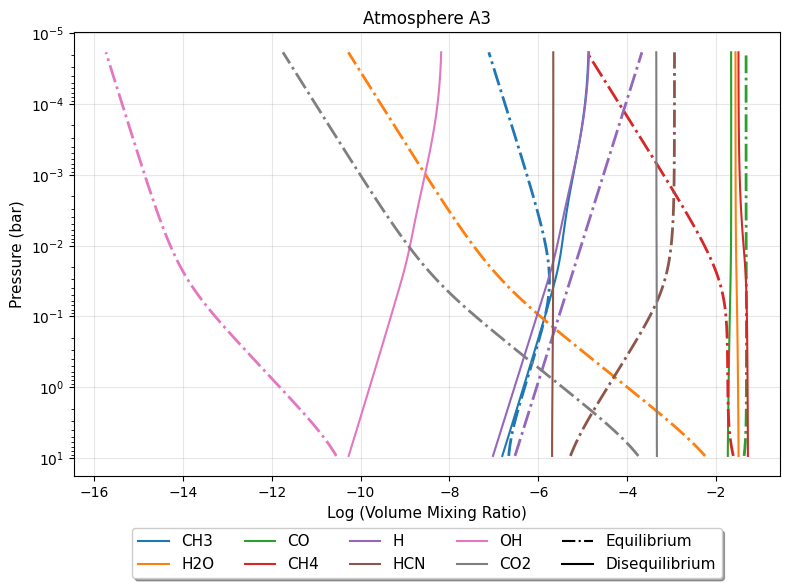

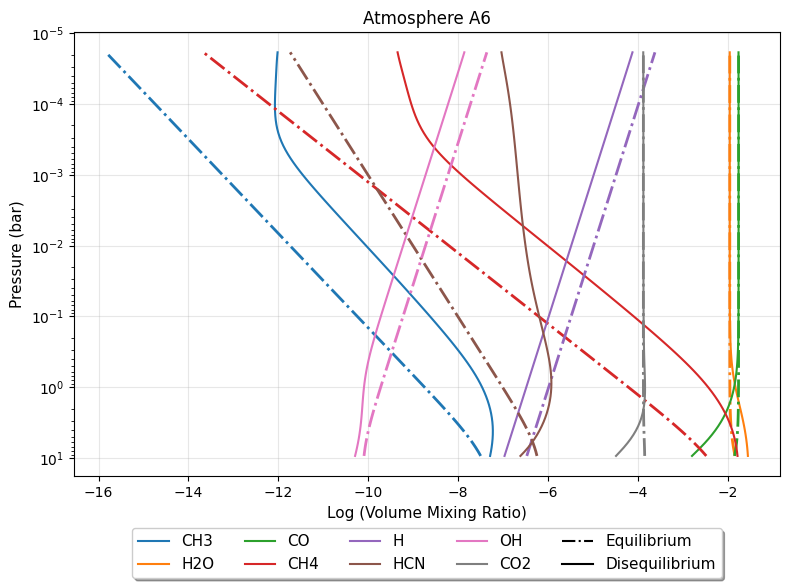

In [8]:
chosen_molecules = ['CH3', 'H2O', 'CO','CH4','H','HCN','OH','CO2']
logVMR_vs_pressure_equlibrium_disequilibrium( network_input, ground_truth, 3102,
                                             chosen_molecules, pressure, save=True)
logVMR_vs_pressure_equlibrium_disequilibrium( network_input, ground_truth, 3037,
                                             chosen_molecules, pressure, save=True)

In [ ]:
#Figure 10

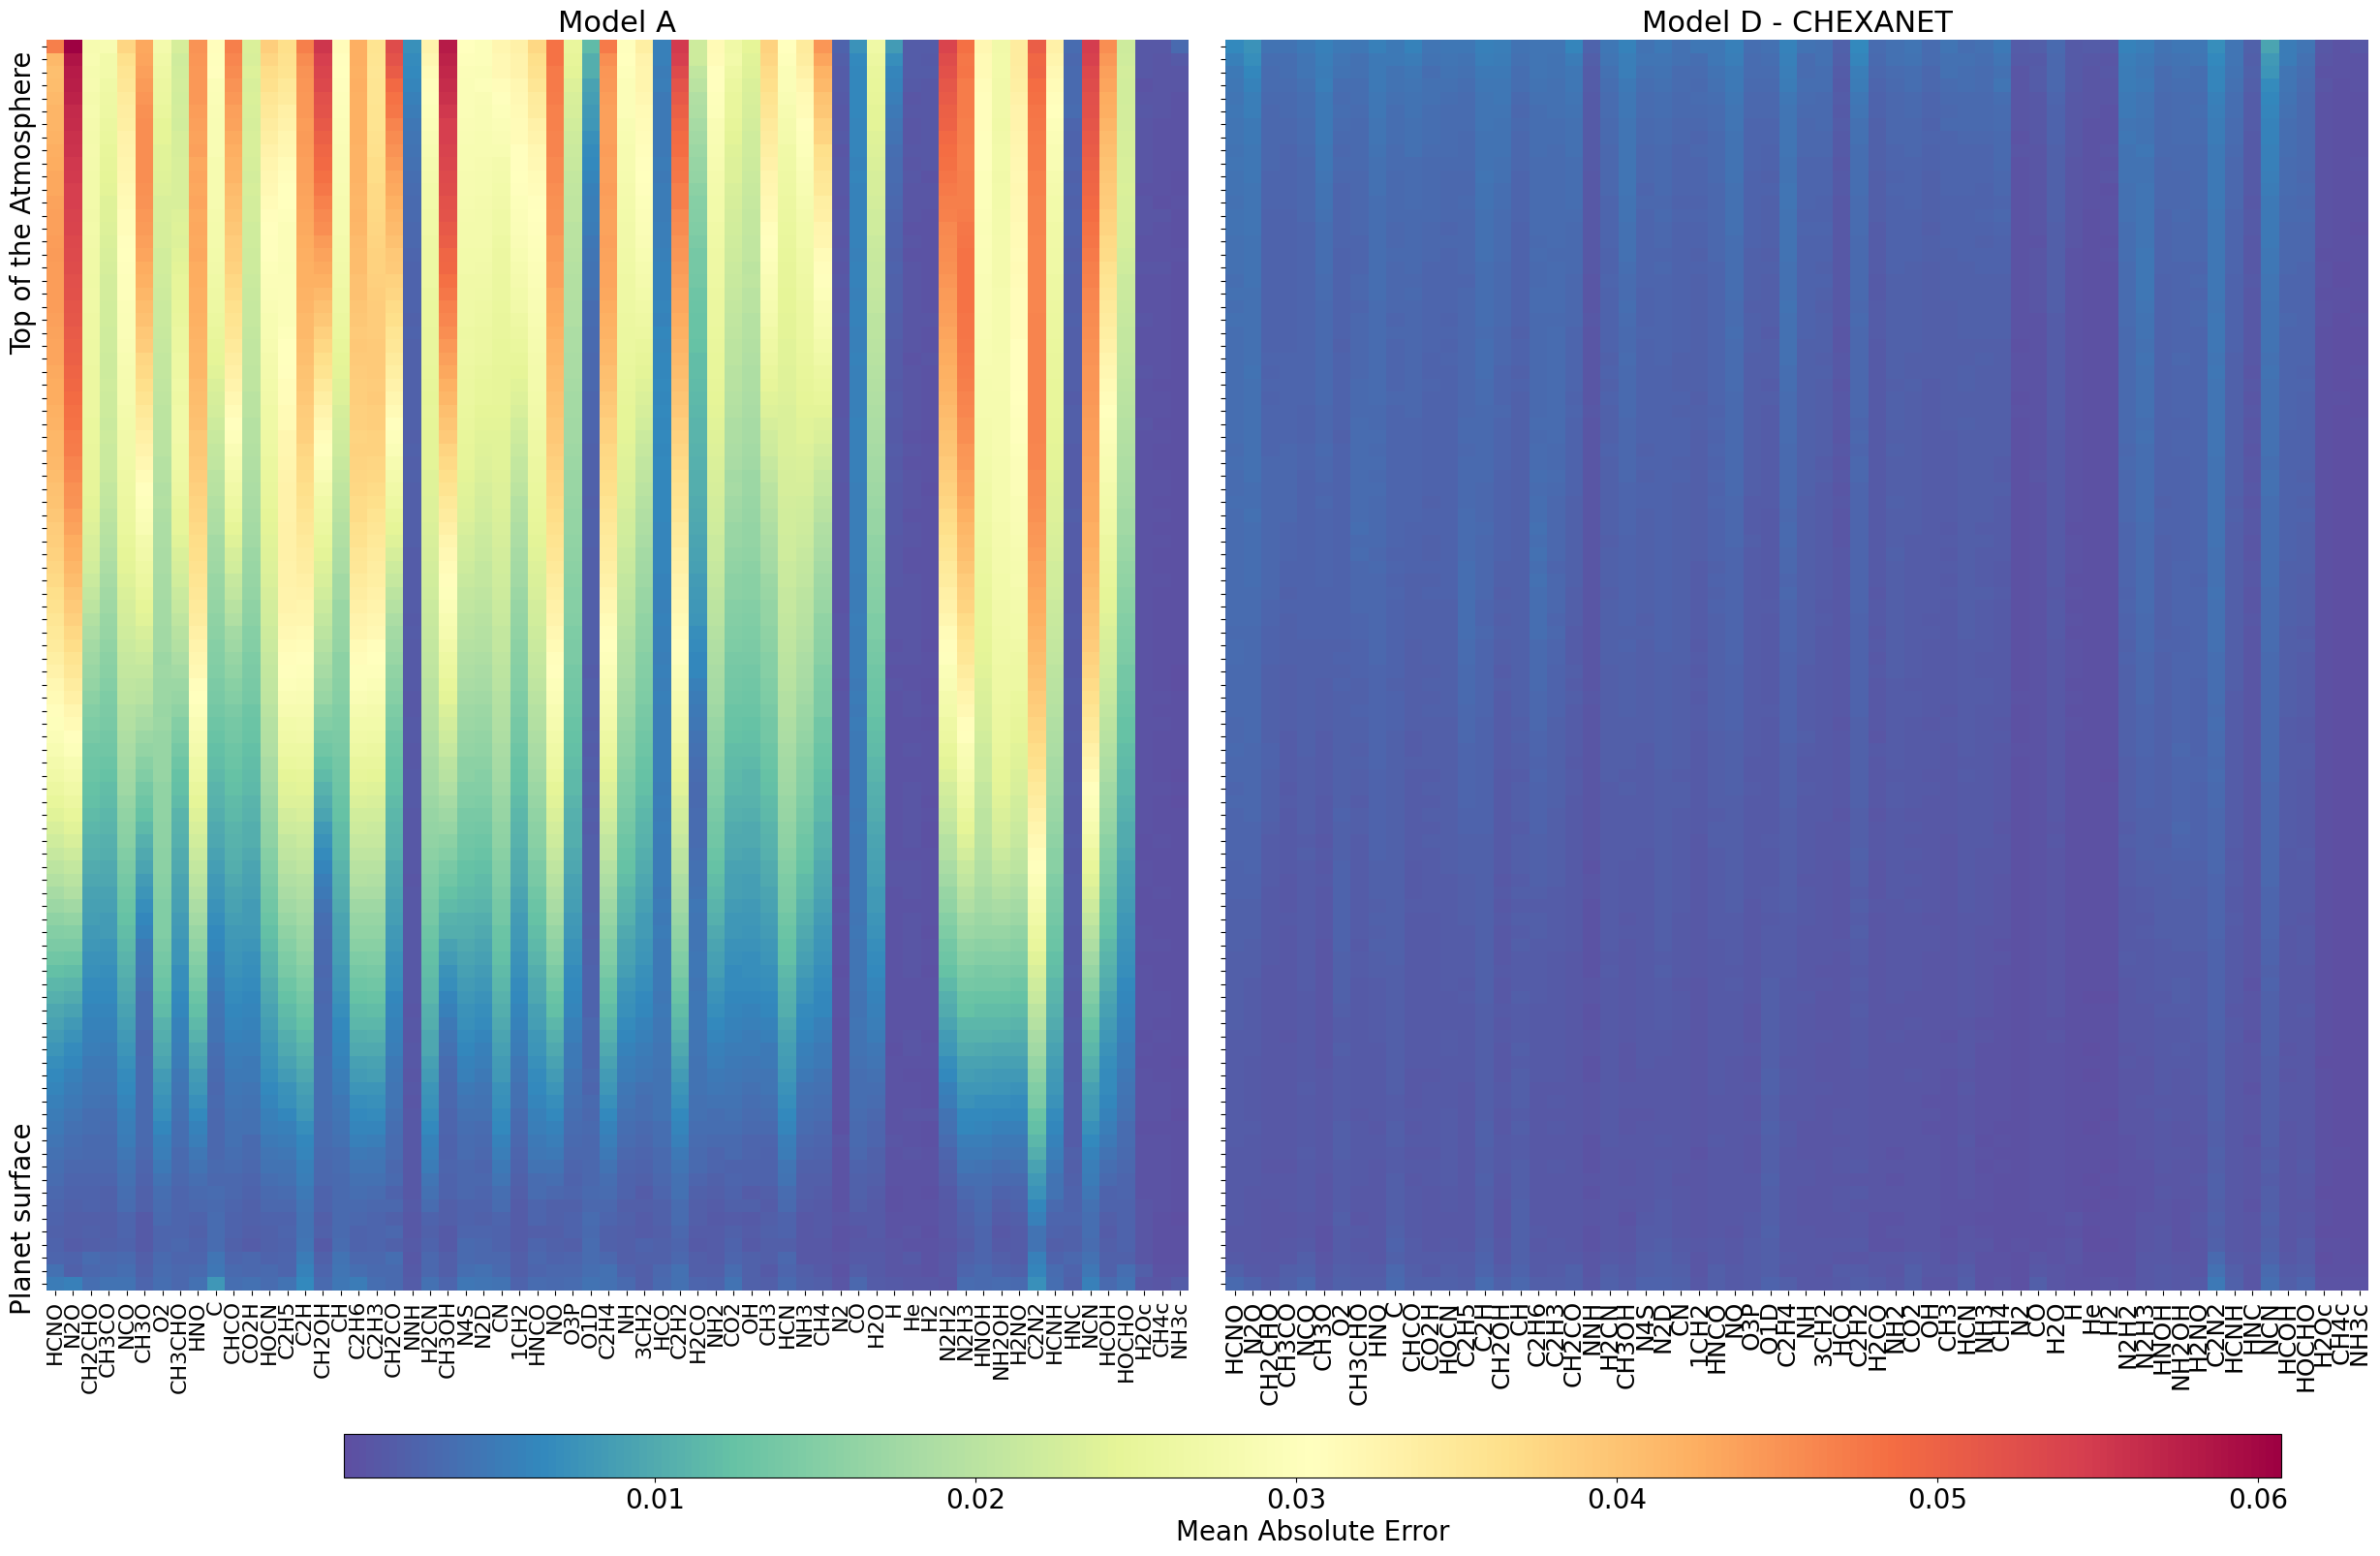

In [39]:
plt.rc('font', size=20)
ylabels = [''] * 96  # Create a list of empty strings for each layer.
ylabels[-13] = 'Top of the Atmosphere'  # Set the first element to 'Top of the Atmosphere'.
ylabels[5] = 'Planet surface'
average_importance_simple =np.mean(np.abs(network_output_modelA - ground_truth), axis=0)
average_importance_bs8 = np.mean(np.abs(network_output_chexanet - ground_truth), axis=0)
min_val = min(np.min(average_importance_simple), np.min(average_importance_bs8)) # Adjust for your actual data
max_val = max(np.max(average_importance_simple), np.max(average_importance_bs8)) # Adjust for your actual data

# Create figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(25, 15), sharey=True) # Adjust size as needed
# First subplot
sns.heatmap(average_importance_simple.T, cmap='Spectral_r', ax=axes[0],
            xticklabels=molecules, yticklabels=True,
            vmin=min_val, vmax=max_val, cbar=False)
axes[0].set_title(f'Model A', fontsize=22)
#axes[0].set_xlabel('Molecules')
axes[0].invert_yaxis()  # Invert the y-axis to have 'Planet surface' at the bottom.
axes[0].set_yticklabels(ylabels, fontsize=20)  
axes[0].set_xticklabels(molecules, fontsize=16)  
axes[0].tick_params(axis='x', rotation=90)
axes[0].tick_params(axis='y', rotation=90)
# Second subplot
sns.heatmap(average_importance_bs8.T, cmap='Spectral_r', ax=axes[1],
            xticklabels=molecules, yticklabels=True,
            vmin=min_val, vmax=max_val, cbar=False)
axes[1].set_title(f'Model D - CHEXANET', fontsize=22)
#axes[1].set_xlabel('Molecules')
axes[1].invert_yaxis()  # Invert the y-axis to have 'Planet surface' at the bottom.
axes[1].set_yticklabels(ylabels)  # Manually set y-tick labels
axes[1].set_xticklabels(molecules, fontsize=18)  
axes[1].tick_params(axis='x', rotation=90)
axes[1].tick_params(axis='y', rotation=90)


plt.tight_layout()
cbar_ax = fig.add_axes([0.15, -0.03, 0.8, 0.03])  # [left, bottom, width, height]
sm = plt.cm.ScalarMappable(cmap='Spectral_r', norm=plt.Normalize(vmin=min_val, vmax=max_val))
cbar = fig.colorbar(sm, cax=cbar_ax, orientation='horizontal')
cbar.set_label('Mean Absolute Error', fontsize=20)  # Increase fontsize as needed
# To increase the tick label size
cbar.ax.tick_params(labelsize=20)
plt.savefig(f'MAE_MA_ME_layer_V2.png', dpi=300,bbox_inches='tight')
plt.show()

In [ ]:
# Figure 11

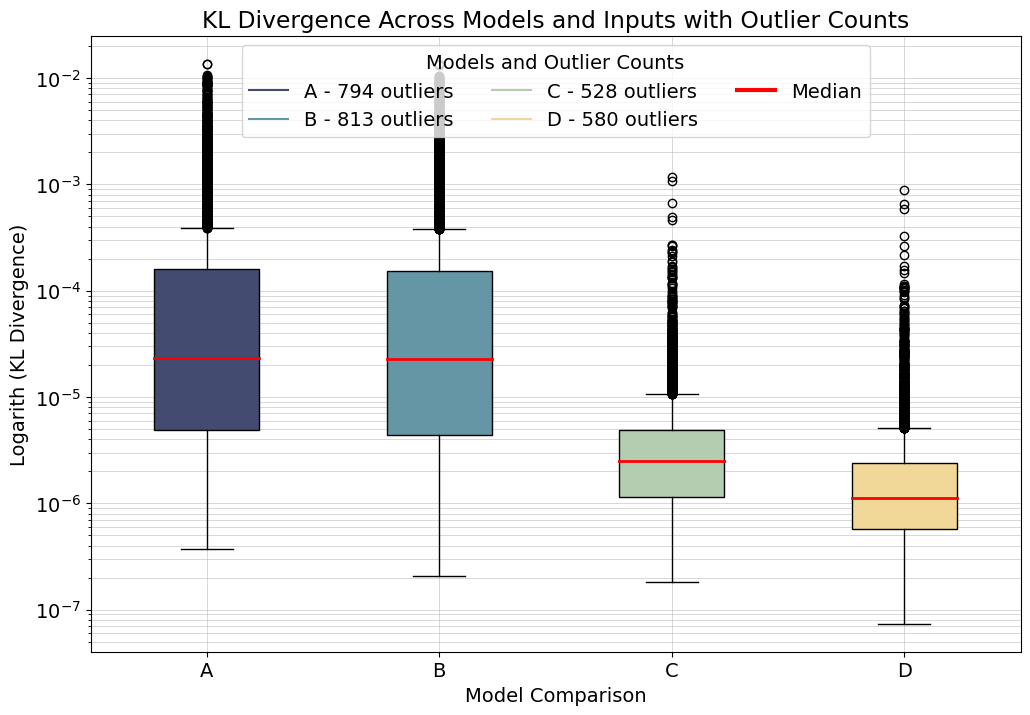

In [12]:
plt.rc('font', size=14)

def calculate_kl_divergence(distribution1, distribution2):
    epsilon = 2  # Small constant to prevent zero probabilities
    dist1_normalized = (distribution1.flatten() + epsilon) / np.sum(distribution1.flatten() + epsilon)
    dist2_normalized = (distribution2.flatten() + epsilon) / np.sum(distribution2.flatten() + epsilon)
    return entropy(dist2_normalized, dist1_normalized)

kl_divergences = []
outliers_count = []
labels = ['A', 'B', 'C', 'D']
network_outputs = [network_output_modelA, network_output_modelB, network_output_modelC,
                   network_output_chexanet]

for output in network_outputs:
    kl_divs = [calculate_kl_divergence(ground_truth[i], output[i]) for i in range(len(ground_truth))]
    kl_divergences.append(kl_divs)
    q1, q3 = np.percentile(kl_divs, [25, 75])
    iqr = q3 - q1
    outlier_threshold = q3 + 1.5 * iqr
    outliers_count.append(sum(x > outlier_threshold for x in kl_divs))

# Custom colors
n_colors = 100
cmap = mcolors.LinearSegmentedColormap.from_list("CustomCmap", ['#444B70', '#6FAEB7', '#F4EBAB', '#E8A065'],
                                                 N=n_colors)
colors = cmap(np.linspace(0, 1, len(labels)+1))

# Create the box plot
plt.figure(figsize=(12, 8))
box = plt.boxplot(kl_divergences, patch_artist=True, labels=labels, showfliers=True)



for patch, color, label, count,median in zip(box['boxes'], colors, labels, outliers_count,box['medians']):
    patch.set_facecolor(color)
    patch.set_label(f"{label} - {count} outliers")
    median.set_color('red')
    median.set_linewidth(2)

# Adding custom legend for outliers
custom_legend = [plt.Line2D([0], [0], color=cmap(i / len(labels)), label=f'{label} - {count} outliers') 
                 for i, (label, count) in enumerate(zip(labels, outliers_count))]
custom_legend.append(plt.Line2D([0], [0], color='red', linewidth=3, label='Median'))
plt.legend(handles=custom_legend, title="Models and Outlier Counts", loc="upper center", ncol=3)
plt.grid(True, which='both', linestyle='-', linewidth=0.5, alpha=0.7)
plt.xlabel('Model Comparison')
plt.ylabel('Logarith (KL Divergence)')
plt.yscale('log')
plt.title('KL Divergence Across Models and Inputs with Outlier Counts')
plt.savefig('KL_div_model_comparison_V2.png', dpi=300,bbox_inches='tight')
plt.show()

In [ ]:
#Figure 12

In [15]:
def plot_error_vs_parameters(df, network_output, ground_truth, labels,save=False):
    for i in range(len(labels)):
        sample_mae = calculate_samplewise_mae(network_output[i], ground_truth)
        df[f'Error{i+1}'] = sample_mae
    fig, axs = plt.subplots(1, len(labels), figsize=(15, 8))  # Create a figure and a set of subplots
    labelsize = 14  # Font size for x and y labels
    titlesize = 14  # Font size for titles
    ticksize = 14   # Font size for tick labels
    #fig.suptitle('Mean Absolute Error vs. Temperature', fontsize=16, y=0.95)  # Set the main title
    colors = ['#444B70','#8BBBB4', '#EFCB8C']
    for i, ax in enumerate(axs):
        sns.scatterplot(ax=ax, x=df['isothermal_T'], y=df[f'Error{i+1}'], color=colors[i],
                        alpha=1, zorder=3, s=40, edgecolor='black', linewidth=0.2 )
        
        q1 = np.percentile(df[f'Error{i+1}'], 25)  # First quartile (Q1)
        q3 = np.percentile(df[f'Error{i+1}'], 75)  # Third quartile (Q3)
        iqr = q3 - q1  # Interquartile range (IQR)
        outlier_threshold = q3 + 1.5 * iqr  # Define outlier threshold
        #print(outlier_threshold)
        #outliers = df[df[f'Error{i+1}'] > outlier_threshold] 
        
        threshold = np.percentile(df[f'Error{i+1}'], 95)  # Calculate the 95th percentile
        #print(threshold)
        outliers = df[df[f'Error{i+1}'] > threshold]      # Get the outliers
        sns.scatterplot(ax=ax, x=outliers['isothermal_T'], y=outliers[f'Error{i+1}'], 
                        color=colors[i], marker='s', s=45, edgecolor='black', linewidth=0.2,
                        zorder=4, label='Outliers')
        if i == 0:
            sns.scatterplot(ax=ax, x=[1400], y=[0.02], color=colors[i],
                        alpha=1, zorder=3, s=40, edgecolor='black', linewidth=0.2, label = 'Model A' )
            sns.scatterplot(ax=ax, x=df['isothermal_T'], y=df[f'Error{3}'],marker = '*', color=colors[2],
                            zorder=3, s=200, edgecolor='black', linewidth=0.6, label = 'Model D' )
            plt.legend()
        ax.set_xlabel('Isothermal Temperature [K]', fontsize=labelsize)
        ax.set_ylabel('MAE', fontsize=labelsize)
        ax.tick_params(labelsize=ticksize)
        ax.grid(alpha=0.5, zorder=0)
        ax.set_facecolor('white')
        ax.set_title(f'Model {labels[i]}', fontsize=titlesize)  # Set the subplot title
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust the layout
    if save:
        plt.savefig(f'MAE_vs_Temperature_V2.png', dpi=300,bbox_inches='tight')
    plt.show()    


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


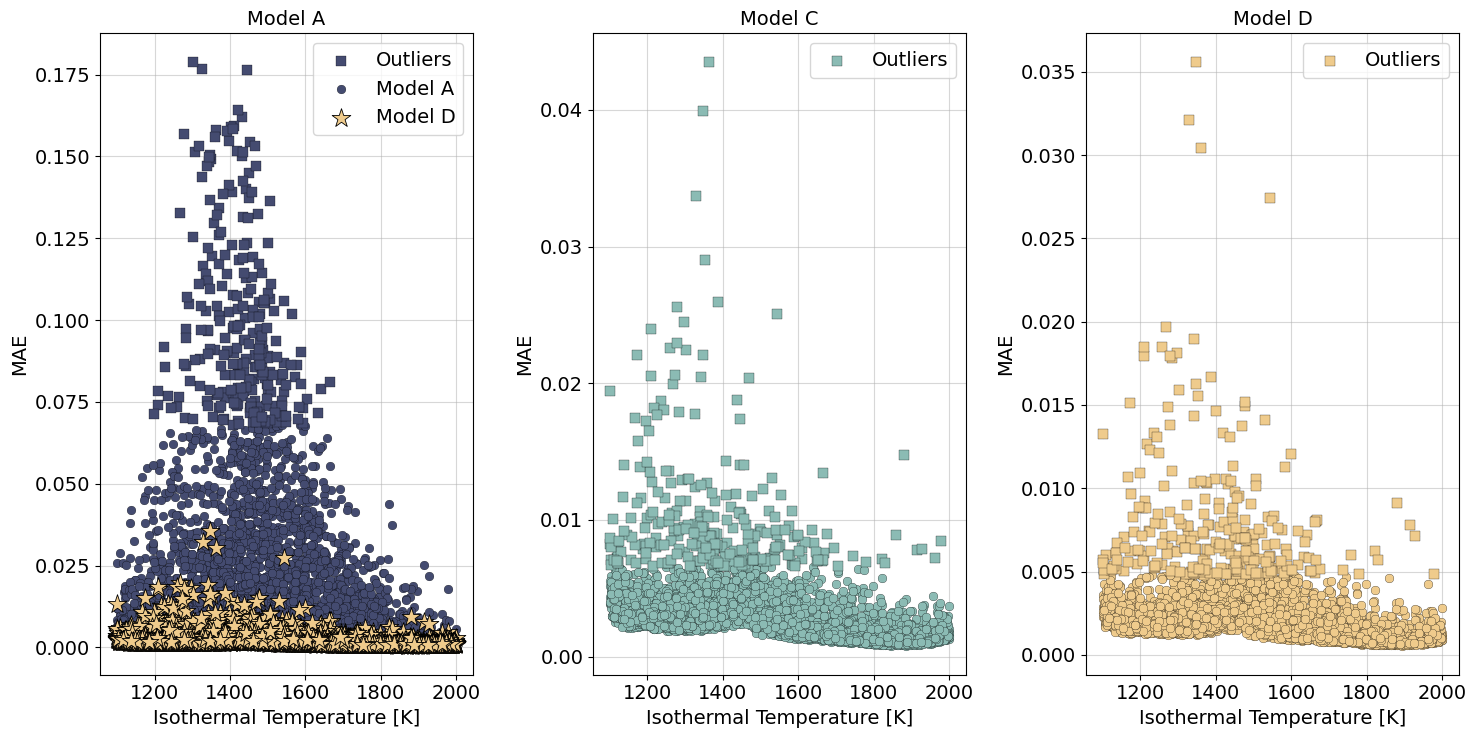

In [16]:
plot_error_vs_parameters(configuration,[network_output_modelA,network_output_modelC, network_output_chexanet],
                         ground_truth,['A','C','D'], save = True)

In [ ]:
# Figure 13

In [21]:
def plot_mae_vs_temperature(network_output, ground_truth, configuration,name, save=False):
    fig, ax = plt.subplots(figsize=(8, 6))
    sample_mae = calculate_samplewise_mae(network_output, ground_truth)
    configuration['Error'] = sample_mae
    # Plot for planet mass
    scatter = ax.scatter(x=configuration['isothermal_T'], y=configuration['Error'],
                         c=configuration['planet_mass'], alpha=1, zorder=3, s=30, 
                         edgecolor='black', linewidth=0.2, cmap='Spectral_r')
    # Creating color bar for planet mass
    cbar = plt.colorbar(scatter)
    cbar.set_label('Planet Mass $M_J$')

    ax.set_xlabel('Isothermal Temperature [K]')
    ax.set_ylabel('Mean Absolute Error')
    ax.set_title(f'Model {name}', fontsize = 13)
    plt.grid(alpha=0.5, zorder=0)
    if save:
        plt.savefig(f'MAE_vs_Temperature_Mass_color_Model{name}.png', dpi=300, bbox_inches='tight')
    plt.show()
    # Plot for C/O Ratio
    fig, ax = plt.subplots(figsize=(8, 6))
    scatter = ax.scatter(x=configuration['isothermal_T'], y=configuration['Error'],
                         c=configuration['co_ratio'], alpha=1, zorder=3, s=30, 
                         edgecolor='black', linewidth=0.2, cmap='Spectral_r')
    # Creating color bar for C/O Ratio
    cbar = plt.colorbar(scatter)
    cbar.set_label('C/O Ratio')

    plt.grid(alpha=0.5, zorder=0)
    ax.set_xlabel('Isothermal Temperature [K]')
    ax.set_ylabel('Mean Absolute Error')
    ax.set_title(f'Model {name}', fontsize = 13)
    
    if save:
        plt.savefig(f'MAE_vs_Temperature_COratio_color_Model{name}.png', dpi=300, bbox_inches='tight')
    plt.show()

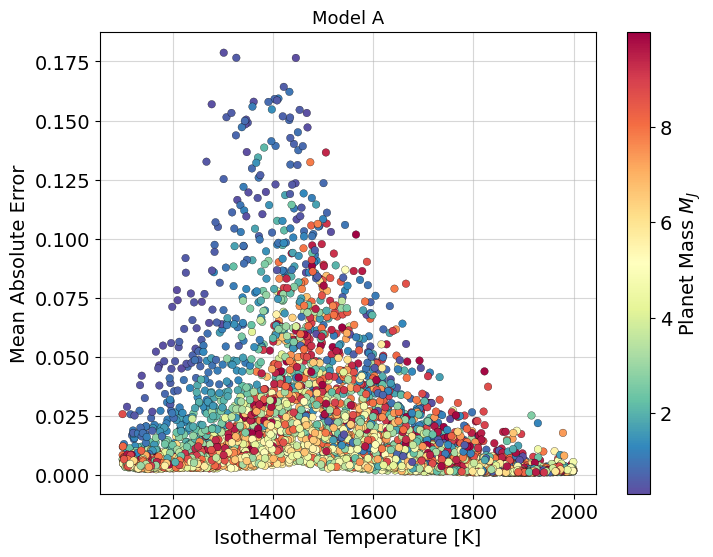

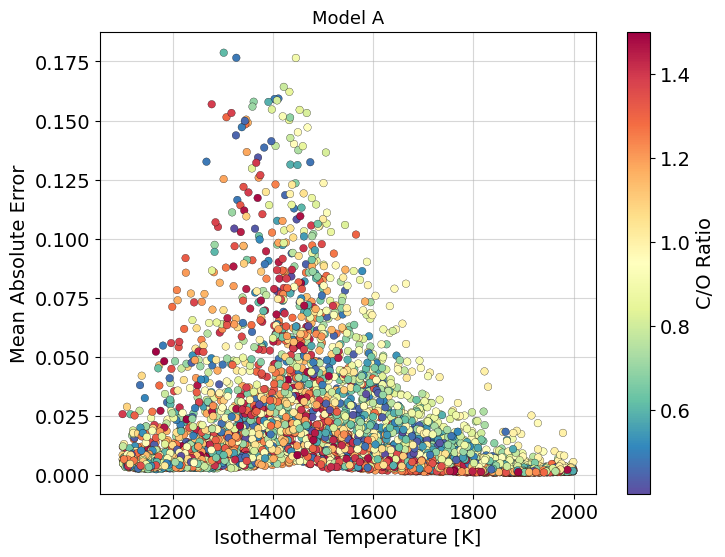

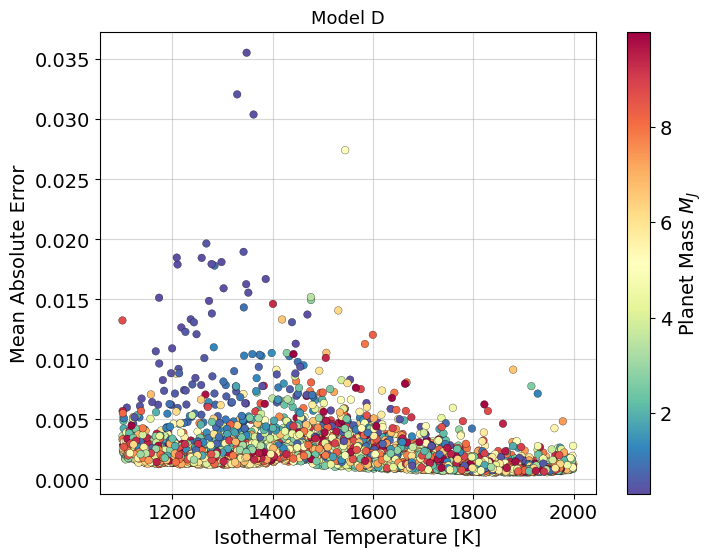

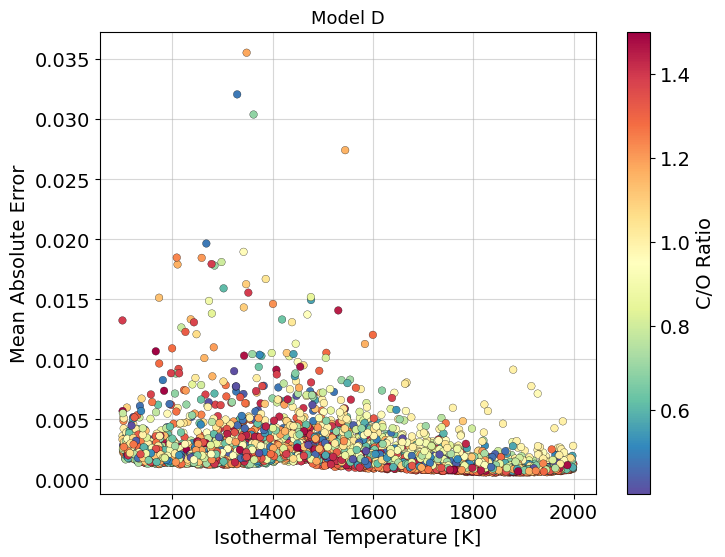

In [22]:
plot_mae_vs_temperature(network_output_modelA, ground_truth, configuration, 'A', save=True)
plot_mae_vs_temperature(network_output_chexanet, ground_truth, configuration, 'D', save=True)

In [ ]:
#Figure 14 and 15

In [25]:
def pair_plot(network_output, ground_truth, configuration, name, save=False):
    color = np.mean(np.abs(network_output - ground_truth), axis=(1, 2))
    norm = plt.Normalize(color.min(), color.max())
    cmap = plt.cm.Spectral_r
    # Define parameters for the plots (original parameter names)
    parameters = ['planet_mass', 'co_ratio', 'isothermal_T', 'metalicity']
    # Mapping to more descriptive axis labels
    label_map = {
        'planet_mass': 'Planet Mass [$M_J$]',
        'co_ratio': 'C/O Ratio',
        'isothermal_T': 'Temperature [K]',
        'metalicity': 'Metalicity'
    }
    n = len(parameters)
    
    # Create subplots
    fig, axs = plt.subplots(n, n, figsize=(5*n, 4*n), constrained_layout=True)
    for i, param_i in enumerate(parameters):
        for j, param_j in enumerate(parameters):
            if i > j:  # Fill only the lower triangle excluding the diagonal
                sc = axs[i, j].scatter(configuration[param_j], configuration[param_i], c=color,
                                       norm=norm, cmap=cmap)

                # Set labels only on the outer axes, using the descriptive names
                if i == n - 1:  # Bottom row
                    axs[i, j].set_xlabel(label_map[param_j], fontsize=15)
                if j == 0:  # Left-most column
                    axs[i, j].set_ylabel(label_map[param_i], fontsize=15)        
            else:
                fig.delaxes(axs[i][j])  # Remove unused subplots
    plt.tight_layout(pad=3.0)
    plt.suptitle(f'Model {name}: Distribution of Initial Exoplanet Parameters colored by MAE',
                 x=0.3, y=0.75, fontsize=15)
    fig.subplots_adjust(right=0.8)  # Make room for the colorbar
    cbar_ax = fig.add_axes([0.1,-0.02, 0.4, 0.02])  # Adjusted position
    cbar = fig.colorbar(sc, cax=cbar_ax, orientation='horizontal')  # Correct orientation
    cbar_ax.yaxis.set_label_position("left")
    cbar_ax.set_title('Mean Absolute Error', pad=10, fontsize=11)
    if save:
        plt.savefig(f'initial_parameters_{name}_V2.png', dpi=1000, bbox_inches='tight')
    plt.show()

The figure layout has changed to tight


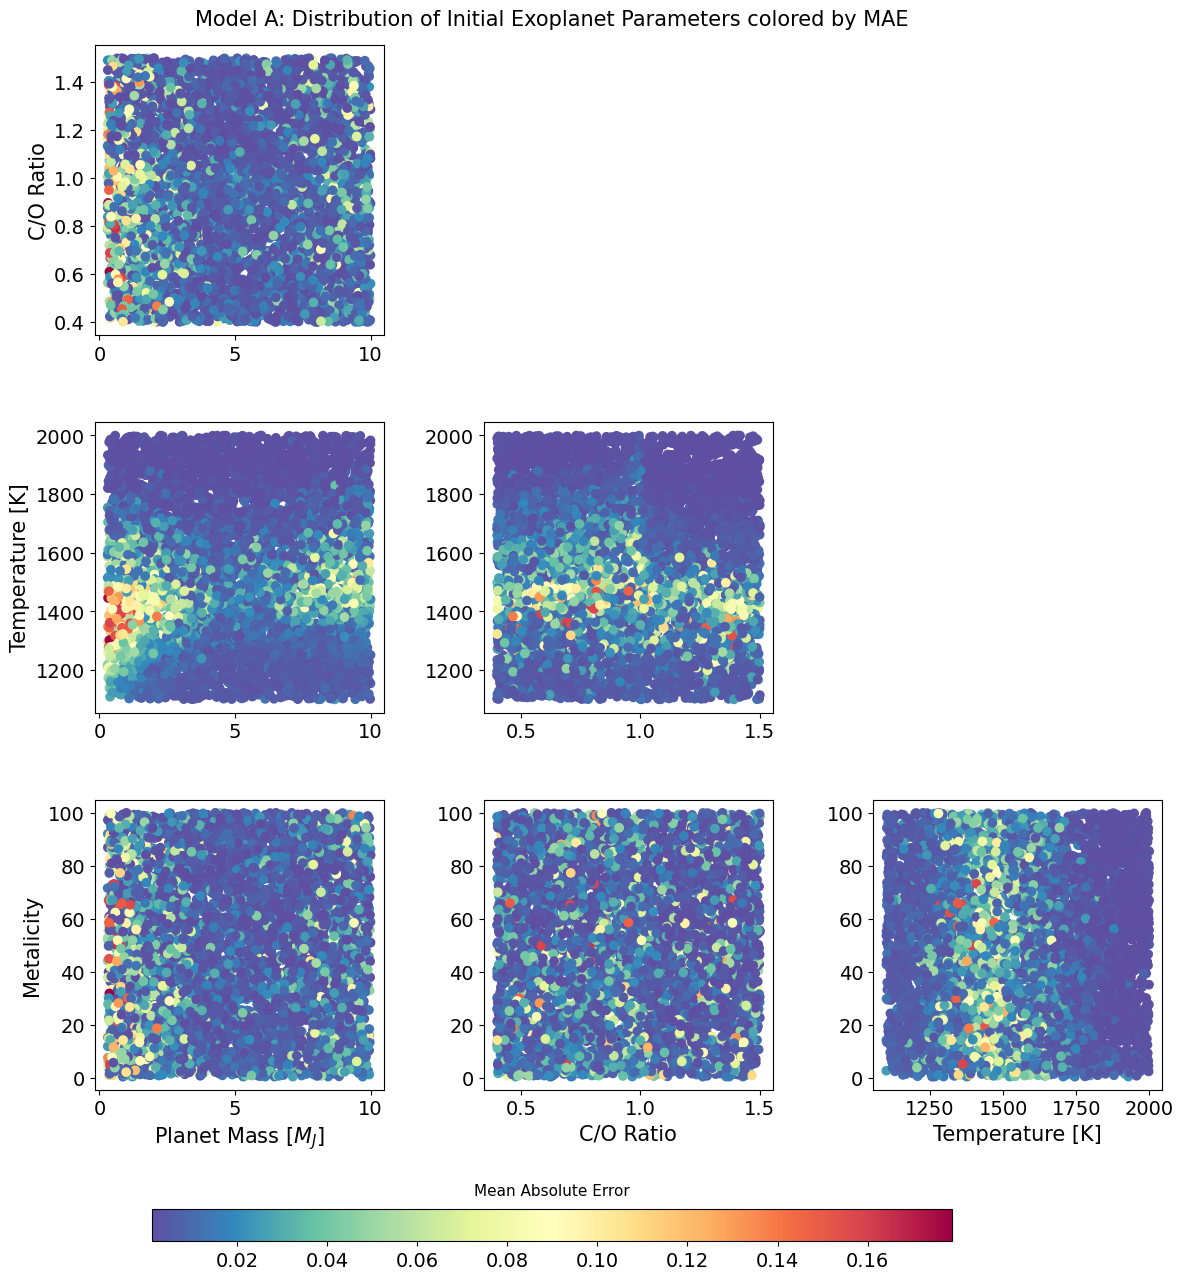

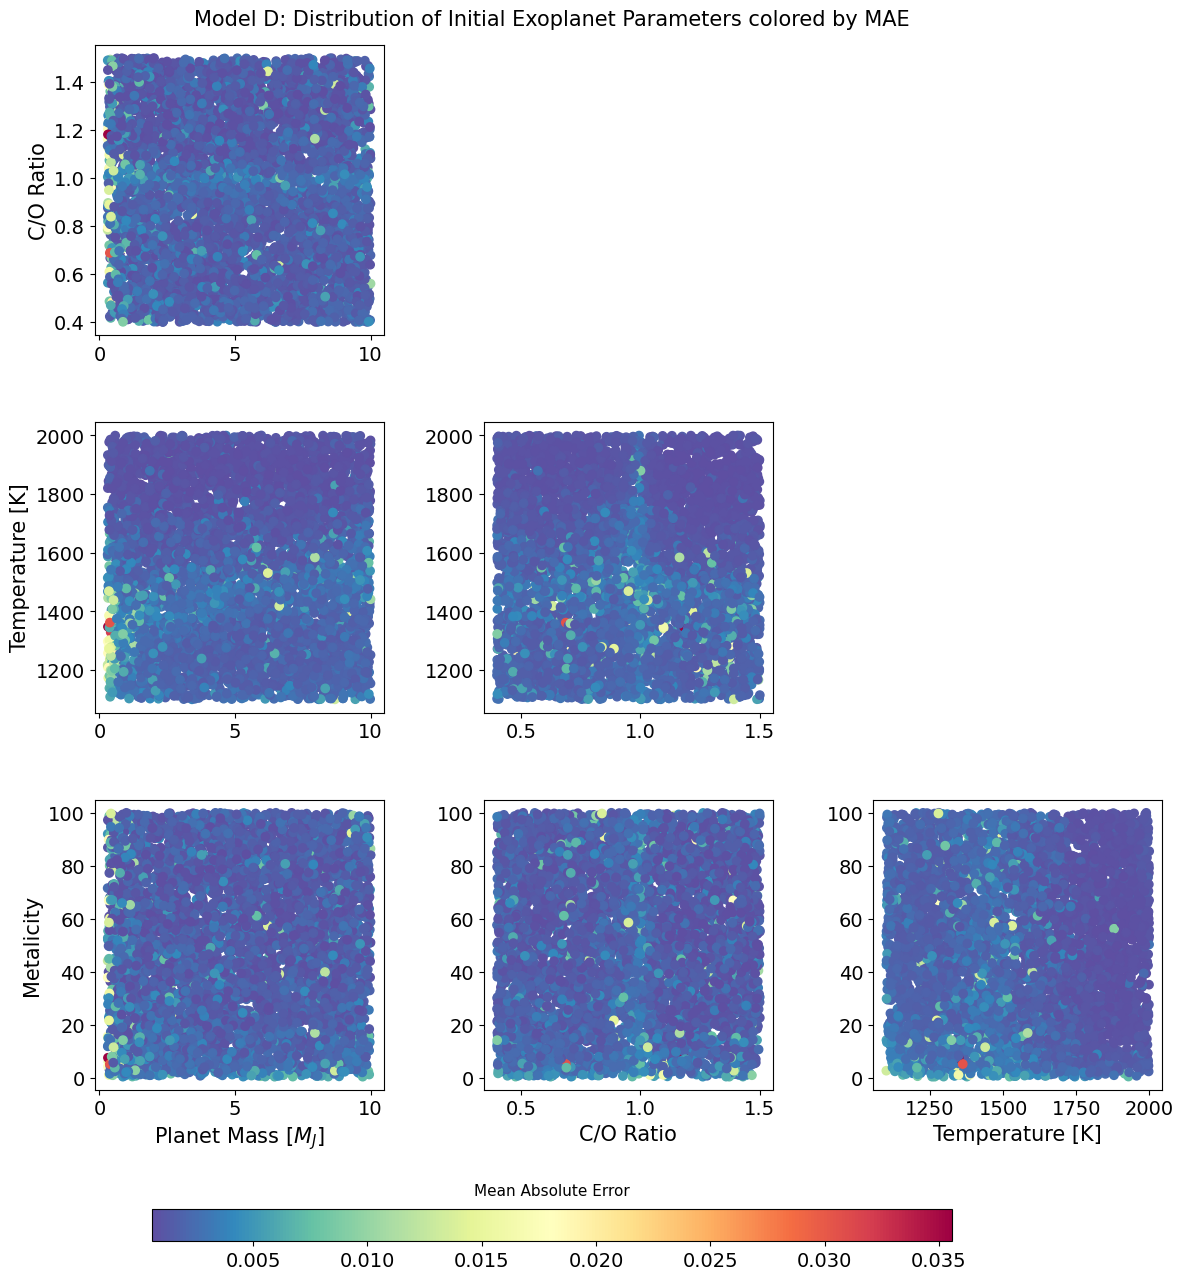

In [26]:
pair_plot(network_output_modelA,ground_truth, configuration, 'A', save = True)
print('=='*50)
pair_plot(network_output_chexanet,ground_truth, configuration, 'D', save = True)

In [ ]:
pair_plot(network_output_chexanet,ground_truth, configuration, 'D', save = False)

In [ ]:
#Figure 16 and 17

In [27]:
colors = ['#D55E00', '#56B4E9', '#009E73', '#F0E442'] 
plt.rc('font', size=14)
def gt_vs_predict_one_molecule_one_atmospheres(ground_truth, network_outputs, network_input, n, ind, 
                           labels, configuration, name, index_atmosphere_dict):
    # Extract configuration data for the title
    co, m, t = configuration.loc[n][['co_ratio', 'metalicity', 'isothermal_T']]
    colors = ['#444B70', '#EFCB8C']
    colors_line = ['#444B70', '#a78e62']
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))
    gt_flat = ground_truth[n, ind, :].flatten()
    min_val, max_val = np.inf, -np.inf
    
    gt_sorted_indices = np.argsort(gt_flat)
    gt_sorted = gt_flat[gt_sorted_indices]
    
    for i, network_output in enumerate(network_outputs):
        output_flat = network_output[n, ind, :].flatten()
        residuals = output_flat - gt_flat
        residuals_sorted = residuals[gt_sorted_indices]
        label = labels[i] if i < len(network_outputs) else 'Input'
        markers = ['o','*']
        ms_l=[60,120]
        s_res = ['--','-.']
        # For better visibility, adjust line styles or markers
        ax1.scatter(gt_flat, output_flat, marker = markers[i], 
                    s=ms_l[i], color=colors[i], label=label, edgecolors='black', lw=1)
        
        # Line plot for residuals
        ax2.plot(gt_sorted, residuals_sorted, s_res[i], color=colors_line[i], label=label, lw=2)

        min_val = min(min_val, gt_flat.min(), output_flat.min())
        max_val = max(max_val, gt_flat.max(), output_flat.max())
        
    input_flat = network_input[n, ind, :].flatten()
    label ='Input'
    ax1.plot(gt_flat, input_flat, '^',ms=8, color='#D55E00', label=label)
        
    # Line plot for residuals
    ax1.plot([min_val, max_val], [min_val, max_val], 'k--', lw=2)  # Line of equality
    ax1.set_xlabel('Ground Truth')
    ax1.set_ylabel('Predicted/Input')
    ax1.set_title(f'Molecule {name}, Atmosphere {index_atmosphere_dict[n]}', fontsize = 14)
    ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=True, ncol=len(labels)+1)
    ax2.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2), fancybox=True, shadow=True, ncol=len(labels))
    ax2.hlines(0, min_val, max_val, colors='k', linestyles='-', lw=2)  # Zero error line
    ax2.set_xlabel('Ground Truth')
    ax2.set_ylabel('Residuals')
    ax2.set_title('Residuals Plot (Sorted)', fontsize = 14)
    ax1.set_xlim(np.min(output_flat), max_val)
    ax2.set_xlim(np.min(output_flat), max_val)
    for ax in [ax1, ax2]:
        ax.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig(f'Error_plot_atmosphere{n}_molecule{name}_A2.png', dpi=300,bbox_inches='tight')
    plt.show()


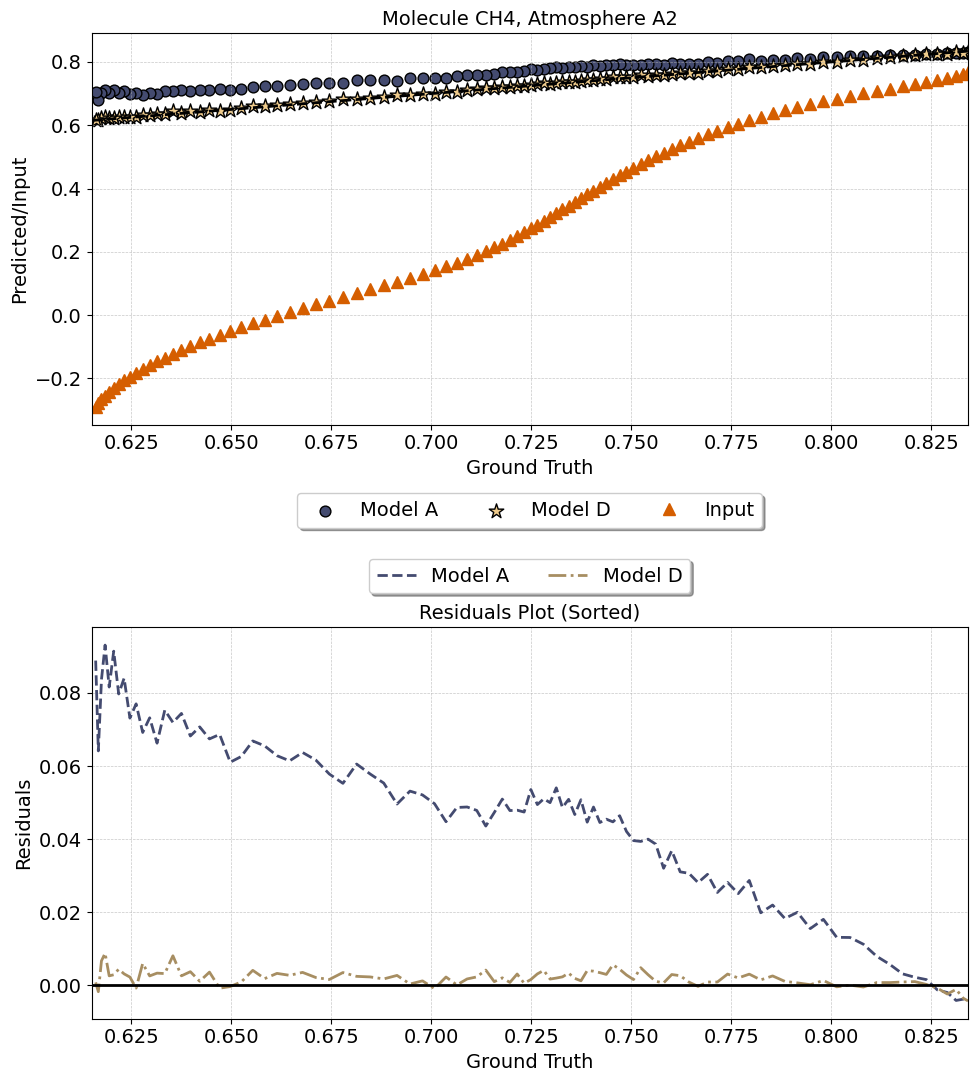

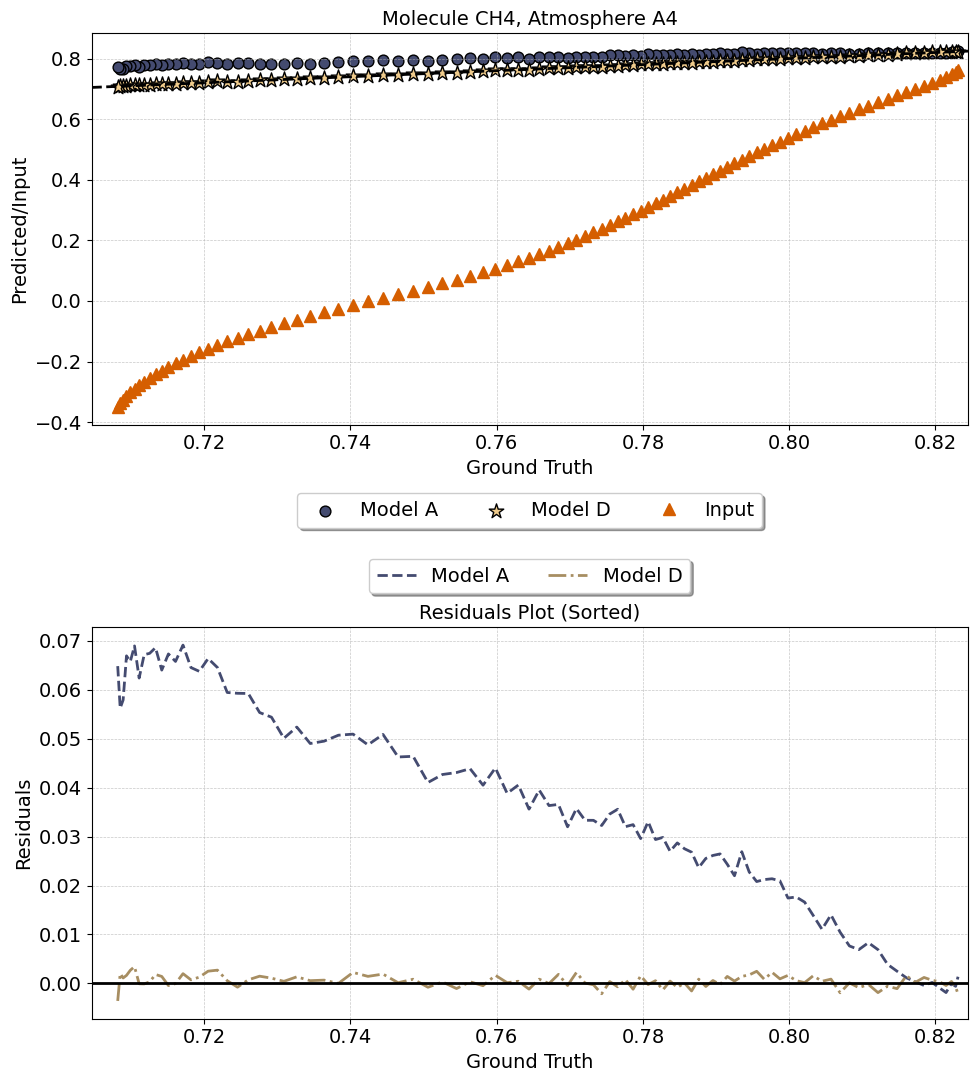

In [28]:
labels = ['Model A','Model D']
name = 'CH4'
for atm in [32, 1291]:
    gt_vs_predict_one_molecule_one_atmospheres(ground_truth, [network_output_modelA,  network_output_chexanet], 
                       network_input, atm, molecules.index(name), labels, configuration, name,
                                               index_atmosphere_dict )

In [ ]:
#Figure 18

In [29]:
def gt_vs_predict_one_molecule_all_atmospheres(ground_truth, network_outputs, network_input,
                                     ind, labels, configuration, name):
    # Extract configuration data for the title
    co, m, t = configuration[['co_ratio', 'metalicity', 'isothermal_T']]
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))
    gt_flat = ground_truth[:, ind, :].flatten()
    min_val, max_val = np.inf, -np.inf
    
    gt_sorted_indices = np.argsort(gt_flat)
    gt_sorted = gt_flat[gt_sorted_indices]
    
    input_flat = network_input[:, ind, :].flatten()

    # For better visibility, adjust line styles or markers
    ax1.plot(gt_flat, input_flat, '^', color='#D55E00',alpha=0.05,ms=3)
    ax1.plot([0], [0], '^', color='#D55E00',alpha=0.8,ms=8, label='Input')
    colors = ['#444B70', '#EFCB8C']
    colors_line = ['#444B70', '#a78e62']
    for i, network_output in enumerate(network_outputs):
        output_flat = network_output[:, ind, :].flatten()
        residuals = output_flat - gt_flat
        residuals_sorted = residuals[gt_sorted_indices]
        label = labels[i]
        s = ['o','*']
        s_res = ['--','-.']
        # For better visibility, adjust line styles or markers
        ax1.plot(gt_flat, output_flat, s[i], ms=7, color=colors[i], label=label)
        
        # Line plot for residuals
        ax2.plot(gt_sorted, residuals_sorted, s_res[i], color=colors[i], label=label)

        min_val = min(min_val, gt_flat.min(), output_flat.min())
        max_val = max(max_val, gt_flat.max(), output_flat.max())

    ax1.plot([min_val, max_val], [min_val, max_val], 'k--', lw=2)  # Line of equality
    ax1.set_xlabel('Ground Truth')
    ax1.set_ylabel('Predicted/Input')
    ax1.set_title(f'Molecule {name} in all test atmospheres', fontsize = 14)
    ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=True, ncol=len(labels)+1)
    ax2.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2), fancybox=True, shadow=True, ncol=len(labels))
    ax2.hlines(0, min_val, max_val, colors='k', linestyles='-', lw=2)  # Zero error line
    ax2.set_xlabel('Ground Truth')
    ax2.set_ylabel('Residuals')
    ax2.set_title('Residuals Plot (Sorted)', fontsize = 14)
    ax1.set_xlim(min_val, max_val)
    ax2.set_xlim(min_val, max_val)
    for ax in [ax1, ax2]:
        ax.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig(f'Error_plot_all_atmosphere_molecule_{name}_V2.png', dpi=300,bbox_inches='tight')
    plt.show()

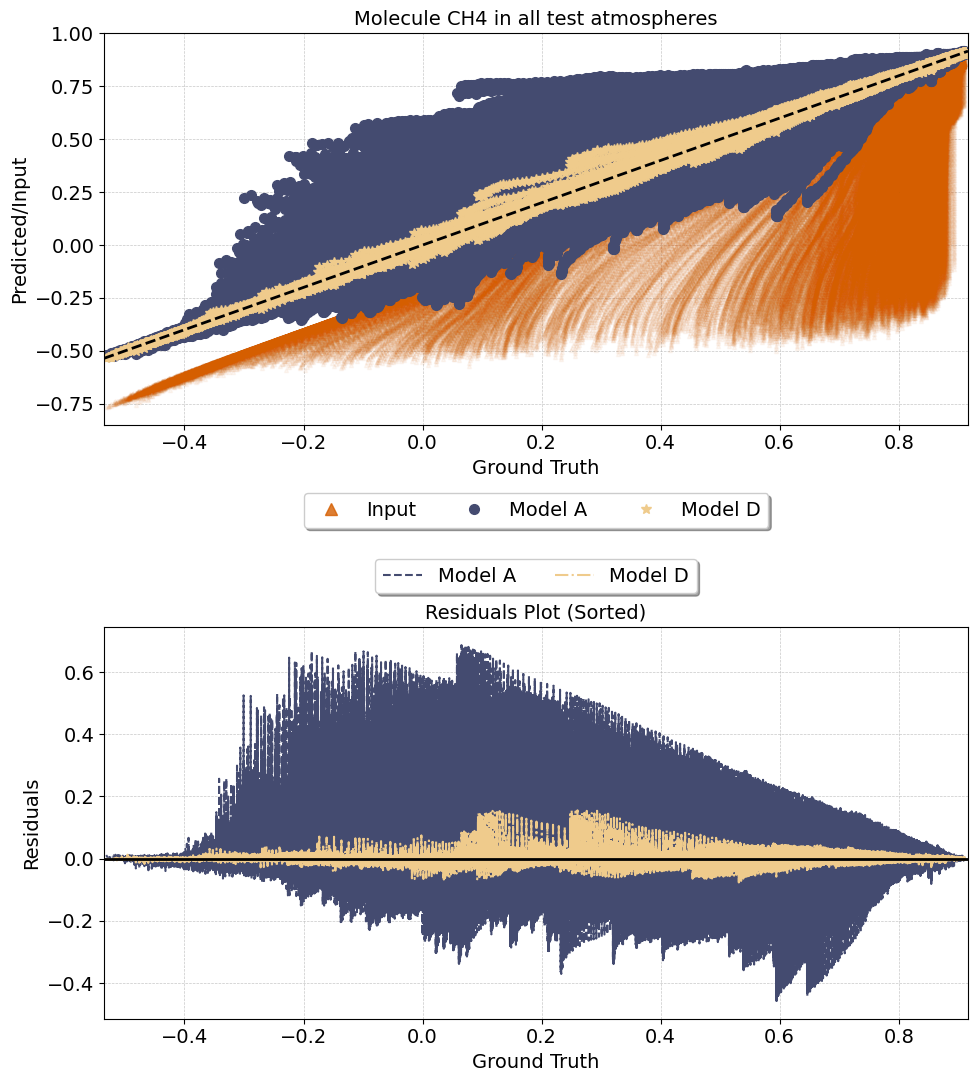

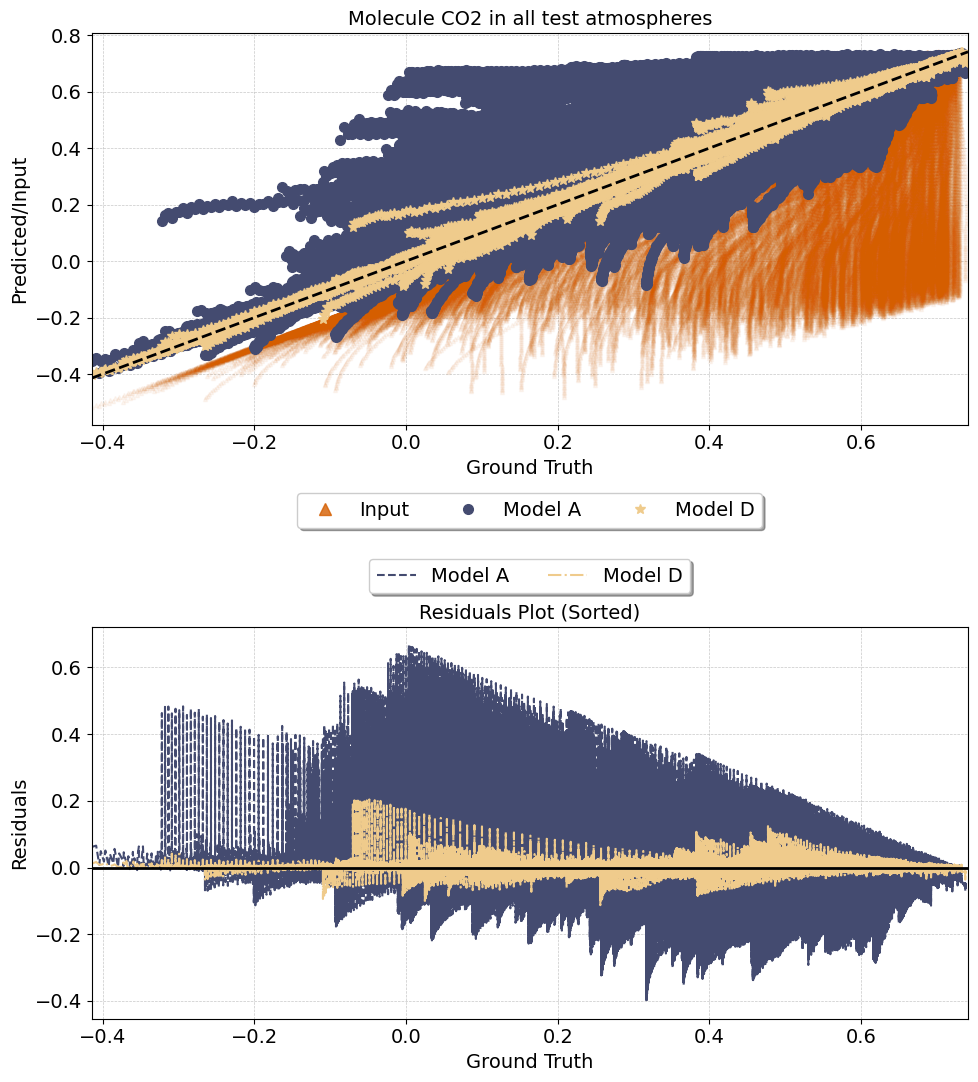

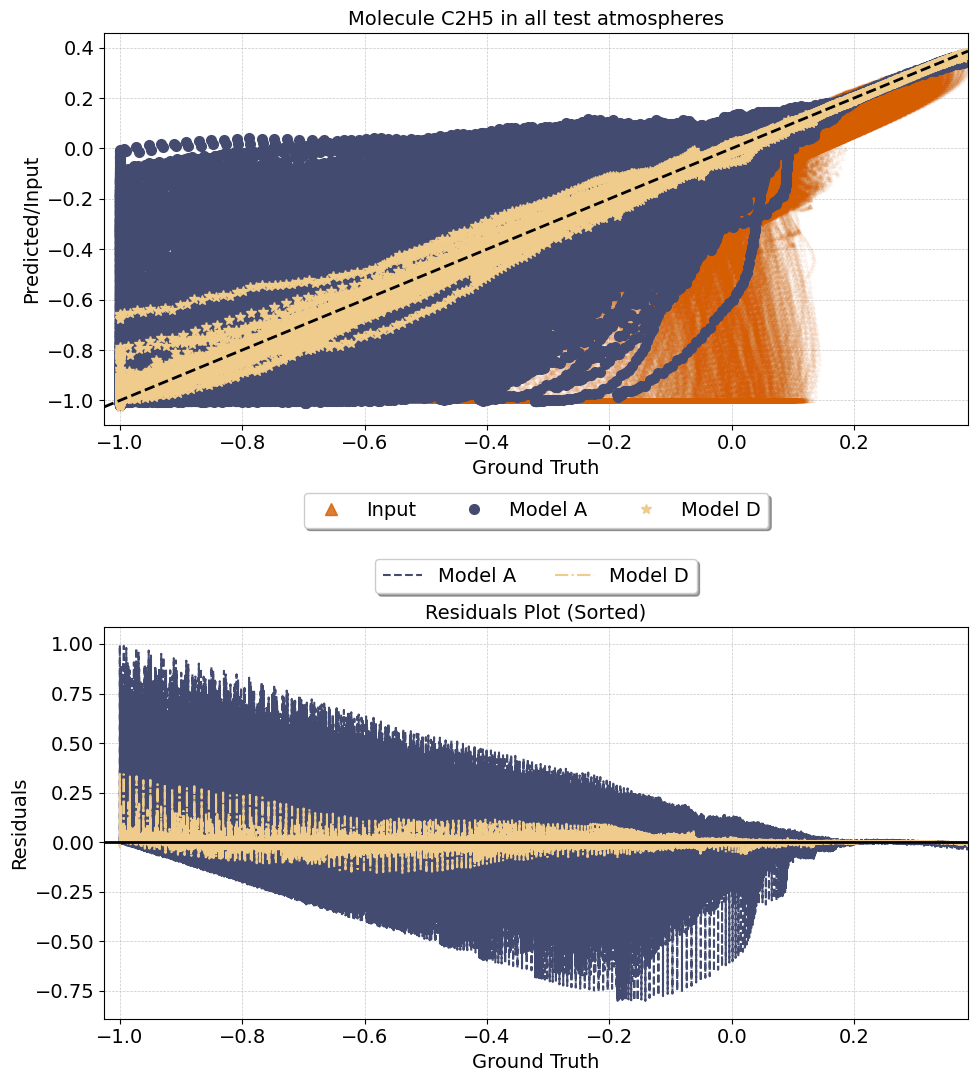

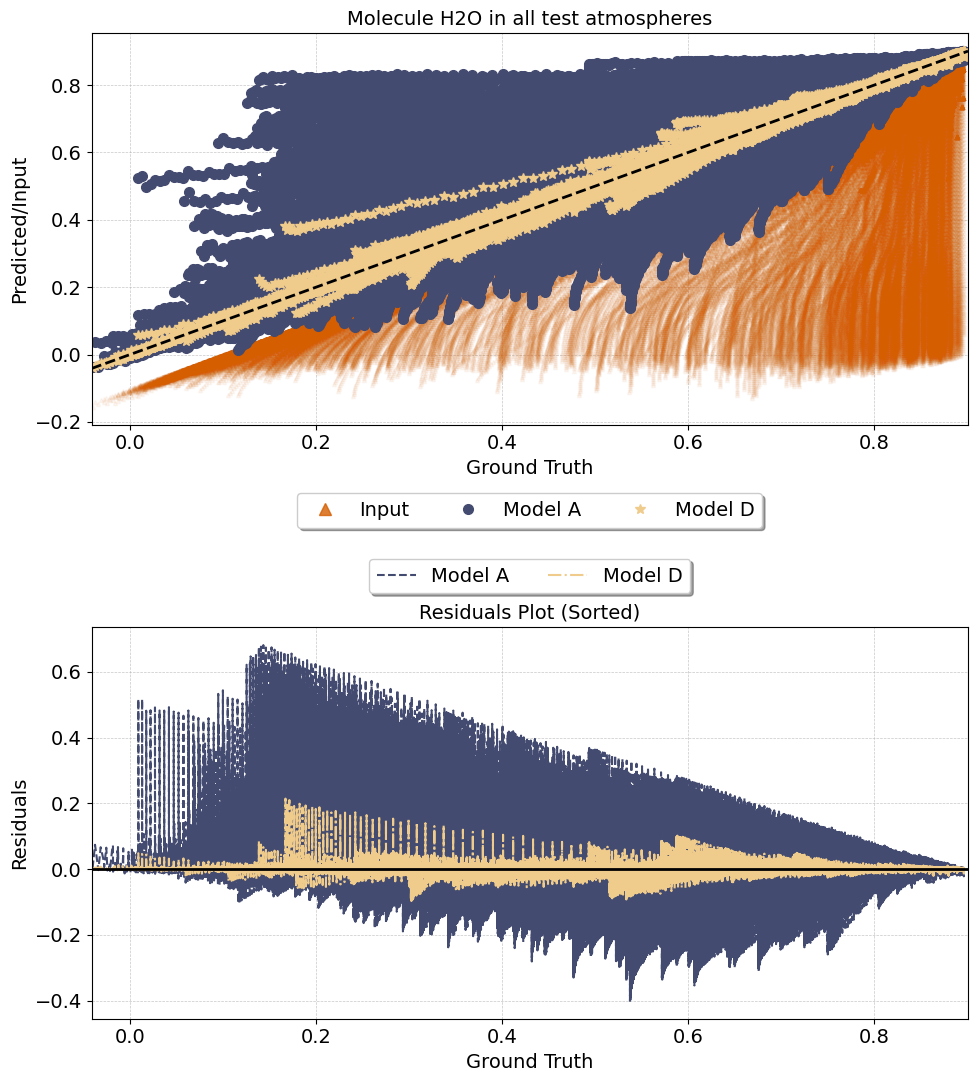

In [30]:
name = 'CH4'
labels = ['Model A','Model D']
gt_vs_predict_one_molecule_all_atmospheres(ground_truth, [network_output_modelA,  network_output_chexanet], 
                       network_input, molecules.index(name), labels, configuration, name)

name = 'CO2'
gt_vs_predict_one_molecule_all_atmospheres(ground_truth, [network_output_modelA,  network_output_chexanet], 
                       network_input, molecules.index(name), labels, configuration, name)

name = 'C2H5'
gt_vs_predict_one_molecule_all_atmospheres(ground_truth, [network_output_modelA,  network_output_chexanet], 
                       network_input, molecules.index(name), labels, configuration, name)

name = 'H2O'
gt_vs_predict_one_molecule_all_atmospheres(ground_truth, [network_output_modelA,  network_output_chexanet], 
                       network_input, molecules.index(name), labels, configuration, name)


In [ ]:
# Figure 19/20

In [32]:
def logVMR_vs_pressure(network_output, network_input, ground_truth, n, chosen_molecules, pascals_values,
                  name=None, save=False):
    if n not in index_atmosphere_dict:
        index_atmosphere_dict[n]=n
    co,m,t= configuration.loc[n][['co_ratio','metalicity','isothermal_T']]
    bars_values = convert_pascals_to_bars(pascals_values)
    
    fig, axs = plt.subplots(2, 1, figsize=(8, 8), gridspec_kw={'height_ratios': [3, 1]})
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f','#daa520']
    # Main plot
    ax = axs[0]
    for i, mol in enumerate(chosen_molecules):
        color = colors[i % len(colors)]
        ax.plot(inverse_preprocessing(network_output[n, molecules.index(mol), :]), bars_values, '--',
                lw=3, label=mol, color=color)
        ax.plot(inverse_preprocessing(ground_truth[n, molecules.index(mol), :]), bars_values, '-',
                lw=1, color=color)

    ax.set_yscale('log')
    ax.invert_yaxis()

    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=True, ncol=5)
   
    ax.grid(alpha=0.3)
    ax.set_title(f'Model {name}, Atmosphere {index_atmosphere_dict[n]}')
    
    ax.set_xlabel('Log (Volume Mixing Ratio)')
    ax.set_ylabel('Pressure (bar)')

    # Define custom lines for the legend here
    line_output = mlines.Line2D([], [], color='black', linestyle='--', linewidth=3, label='Network Output')
    line_truth = mlines.Line2D([], [], color='black', linestyle='-', linewidth=1, label='Ground Truth')

    # Residual plot
    ax_res = axs[1]
    for i, mol in enumerate(chosen_molecules):
        color = colors[i % len(colors)]
        residual = inverse_preprocessing(ground_truth[n, molecules.index(mol), :]) - inverse_preprocessing(network_output[n, molecules.index(mol), :])
        ax_res.plot(residual, bars_values, '.', label=mol, color=color)
    ax_res.legend(handles=[line_output, line_truth],loc='upper center', bbox_to_anchor=(0.5, 1.4),
                  fancybox=True, shadow=True, ncol=2)
    ax_res.set_xlabel('Residual (Ground Truth - Network Output)')
    ax_res.set_ylabel('Pressure (bar)')
    ax_res.grid(alpha=0.3)
    ax_res.invert_yaxis()
    ax_res.set_yscale('log')
    plt.tight_layout()
    if save:
        plt.savefig(f'Atmosphere_{n}_{name}_V2.png')
    plt.show()

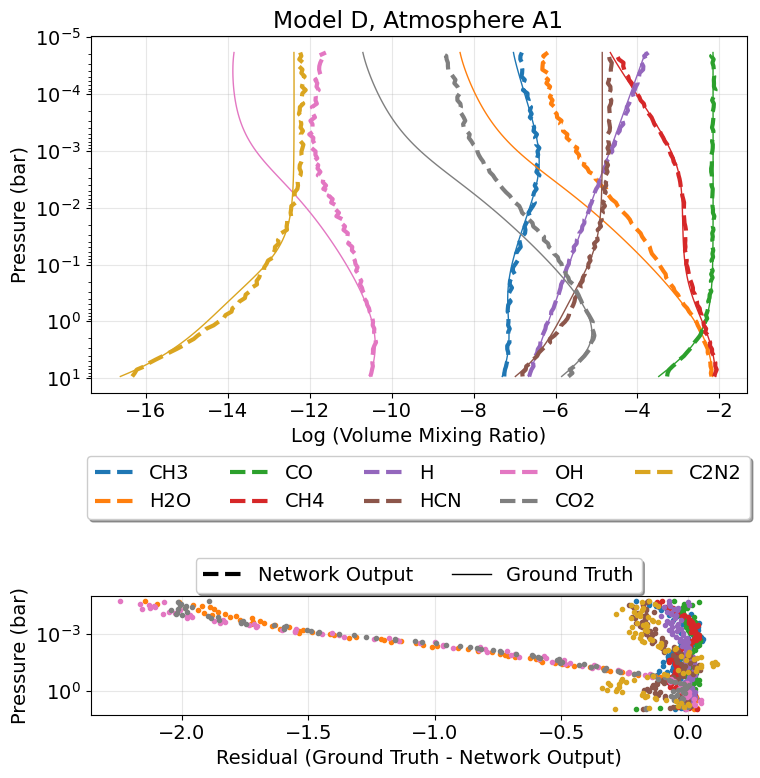

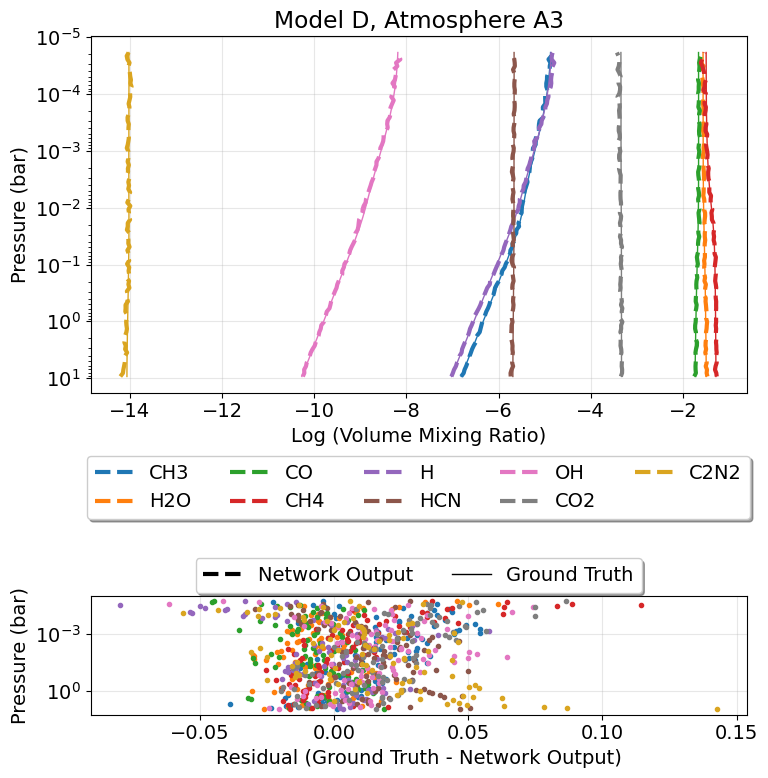

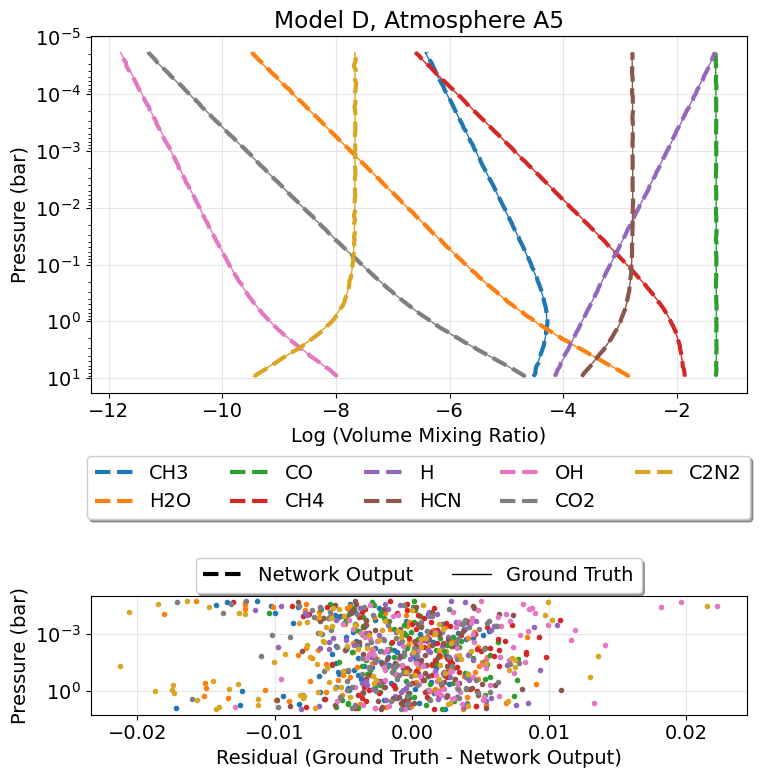

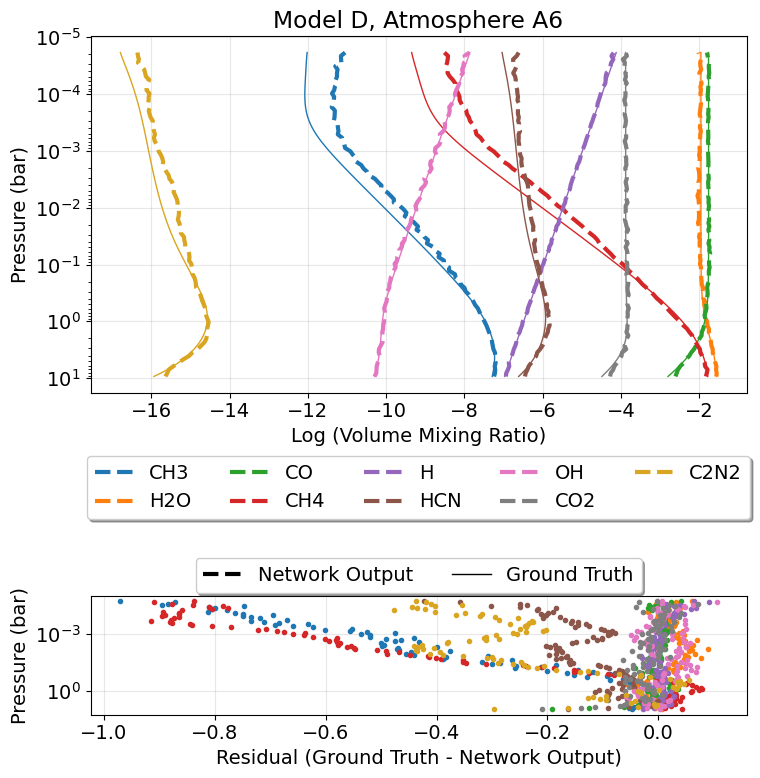

In [33]:
#A1 A5 A3 A6
3423 2730 3102 3037
chosen_molecules = ['CH3', 'H2O', 'CO','CH4','H','HCN','OH','CO2','C2N2']
labels = ['Model A','Model C', 'Model D']

logVMR_vs_pressure(network_output_chexanet, network_input, ground_truth, 3423, 
                   chosen_molecules, pressure, name='D', save=True)
logVMR_vs_pressure(network_output_chexanet, network_input, ground_truth, 3102, 
                   chosen_molecules, pressure, name='D', save=True)
logVMR_vs_pressure(network_output_chexanet, network_input, ground_truth, 2730, 
                   chosen_molecules, pressure, name='D', save=True)
logVMR_vs_pressure(network_output_chexanet, network_input, ground_truth, 3037, 
                   chosen_molecules, pressure, name='D', save=True)

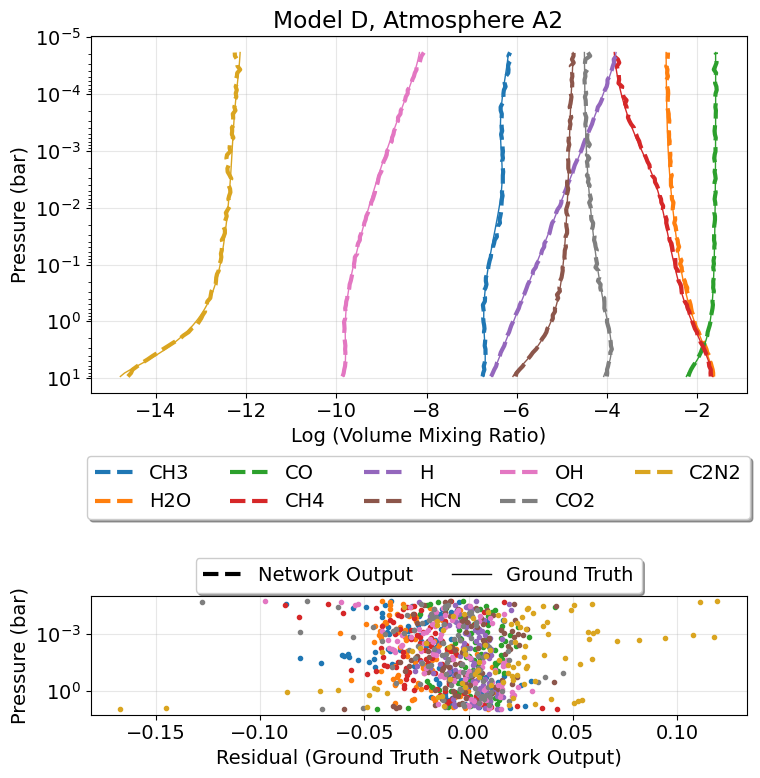

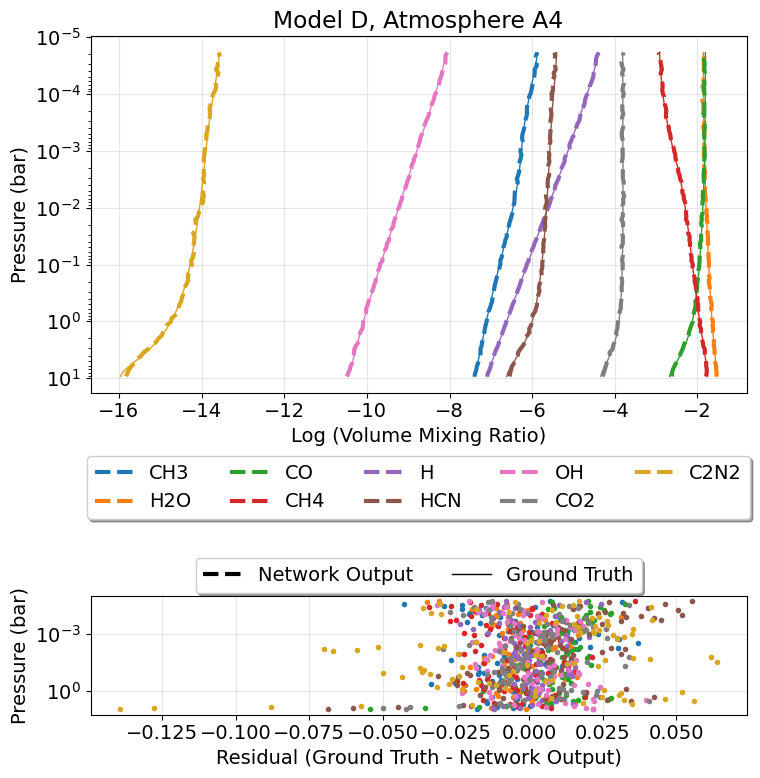

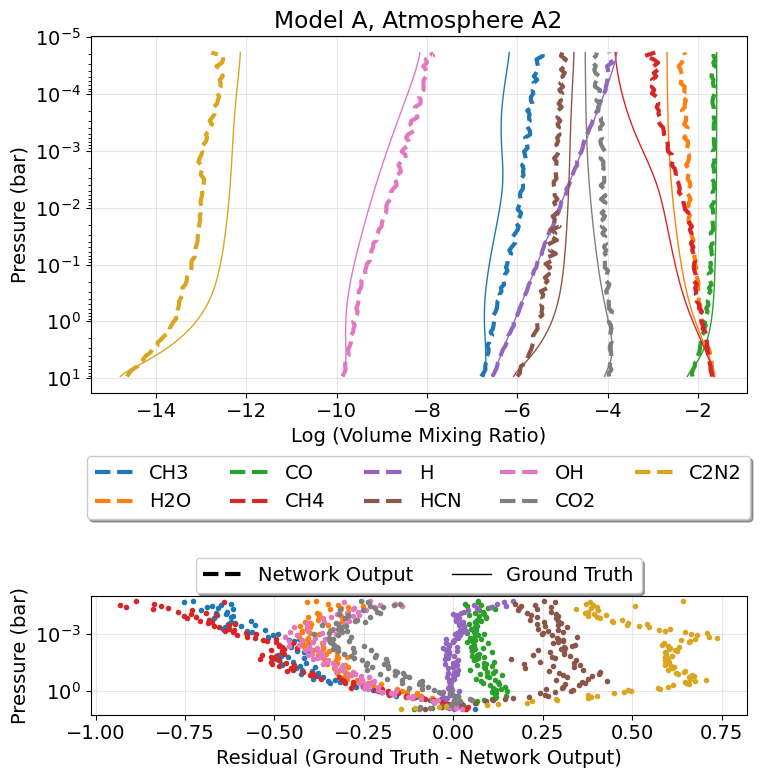

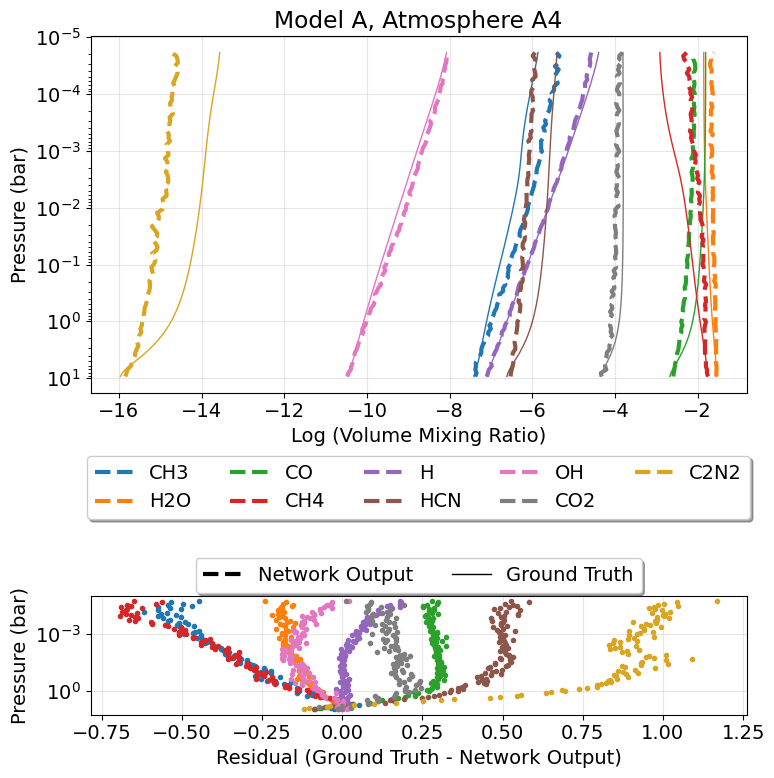

In [34]:
#A2 A4

chosen_molecules = ['CH3', 'H2O', 'CO','CH4','H','HCN','OH','CO2','C2N2']
labels = ['A: Simple Model','C: Unet with Attention and Add info', 'E: Unet with Att, Add Info, DL, bs8']

logVMR_vs_pressure(network_output_chexanet, network_input, ground_truth, 32, 
                   chosen_molecules, pressure, name='D', save=True)
logVMR_vs_pressure(network_output_chexanet, network_input, ground_truth, 1291, 
                   chosen_molecules, pressure, name='D', save=True)
logVMR_vs_pressure(network_output_modelA, network_input, ground_truth, 32, 
                   chosen_molecules, pressure, name='A', save=True)
logVMR_vs_pressure(network_output_modelA, network_input, ground_truth, 1291, 
                   chosen_molecules, pressure, name='A', save=True)

In [ ]:
# Figure 21

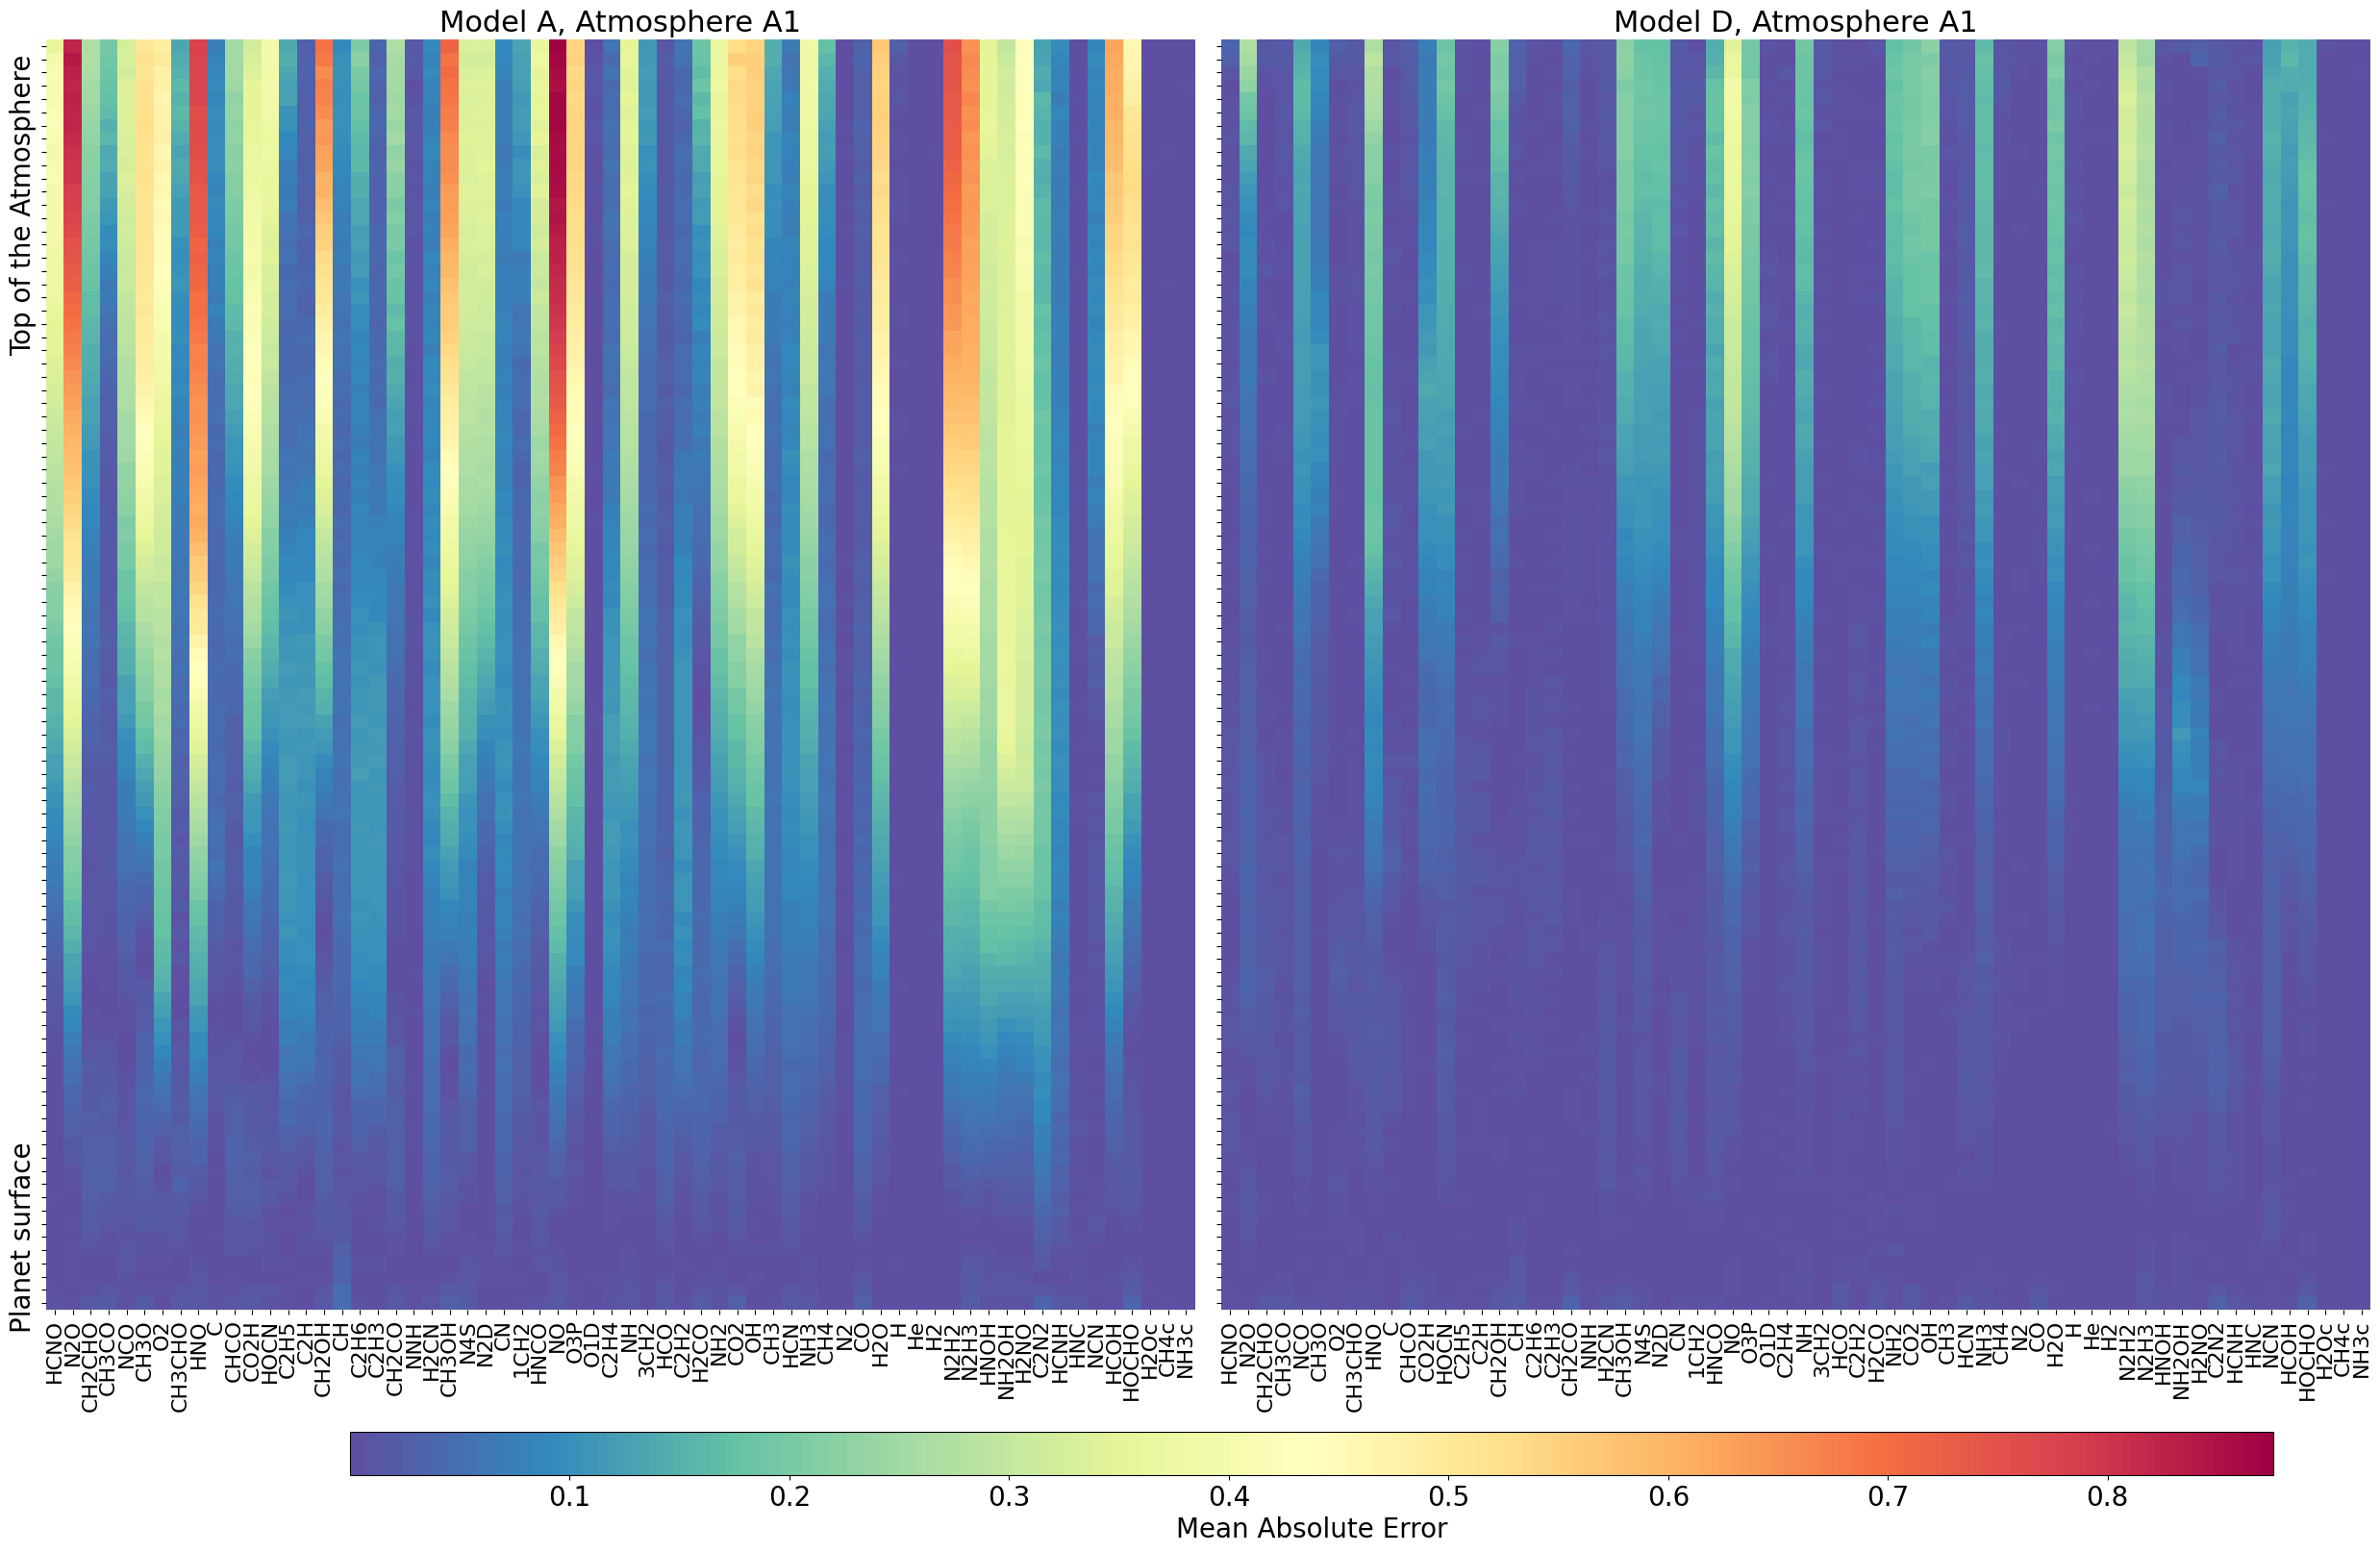

In [37]:
ylabels = [''] * 96  # Create a list of empty strings for each layer.
ylabels[-13] = 'Top of the Atmosphere'  # Set the first element to 'Top of the Atmosphere'.
ylabels[5] = 'Planet surface'

n = 3423
average_importance_simple =np.abs(network_output_modelA[n] - ground_truth[n])
average_importance_bs8 = np.abs(network_output_chexanet[n] - ground_truth[n])
min_val = min(np.min(average_importance_simple), np.min(average_importance_bs8)) # Adjust for your actual data
max_val = max(np.max(average_importance_simple), np.max(average_importance_bs8)) # Adjust for your actual data

fig, axes = plt.subplots(1, 2, figsize=(25, 15), sharey=True)  # Adjust size as needed

# First subplot
sns.heatmap(average_importance_simple.T, cmap='Spectral_r', ax=axes[0],
            xticklabels=molecules, yticklabels=True,
            vmin=min_val, vmax=max_val, cbar=False)
axes[0].set_title(f'Model A, Atmosphere {index_atmosphere_dict[n]}', fontsize=22)
#axes[0].set_xlabel('Molecules')
axes[0].invert_yaxis()  # Invert the y-axis to have 'Planet surface' at the bottom.
axes[0].set_yticklabels(ylabels, fontsize=20)  
axes[0].set_xticklabels(molecules, fontsize=16)  
axes[0].tick_params(axis='x', rotation=90)
axes[0].tick_params(axis='y', rotation=90)
# Second subplot
sns.heatmap(average_importance_bs8.T, cmap='Spectral_r', ax=axes[1],
            xticklabels=molecules,yticklabels=True,
            vmin=min_val, vmax=max_val, cbar=False)
axes[1].set_title(f'Model D, Atmosphere {index_atmosphere_dict[n]}', fontsize=22)
#axes[1].set_xlabel('Molecules')
axes[1].invert_yaxis()  
axes[1].set_yticklabels(ylabels)  
axes[1].set_xticklabels(molecules, fontsize=16)  
axes[1].tick_params(axis='x', rotation=90)
axes[1].tick_params(axis='y', rotation=90)

plt.tight_layout()
cbar_ax = fig.add_axes([0.15, -0.03, 0.8, 0.03])  # [left, bottom, width, height]
sm = plt.cm.ScalarMappable(cmap='Spectral_r', norm=plt.Normalize(vmin=min_val, vmax=max_val))
cbar = fig.colorbar(sm, cax=cbar_ax, orientation='horizontal')
cbar.set_label('Mean Absolute Error', fontsize=20)  # Increase fontsize as needed
# To increase the tick label size
cbar.ax.tick_params(labelsize=20)
# Uncomment the line below to save the figure
plt.savefig(f'MAE_MA_ME_layer_Atmosphere{index_atmosphere_dict[n]}_V2.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# Figure 22

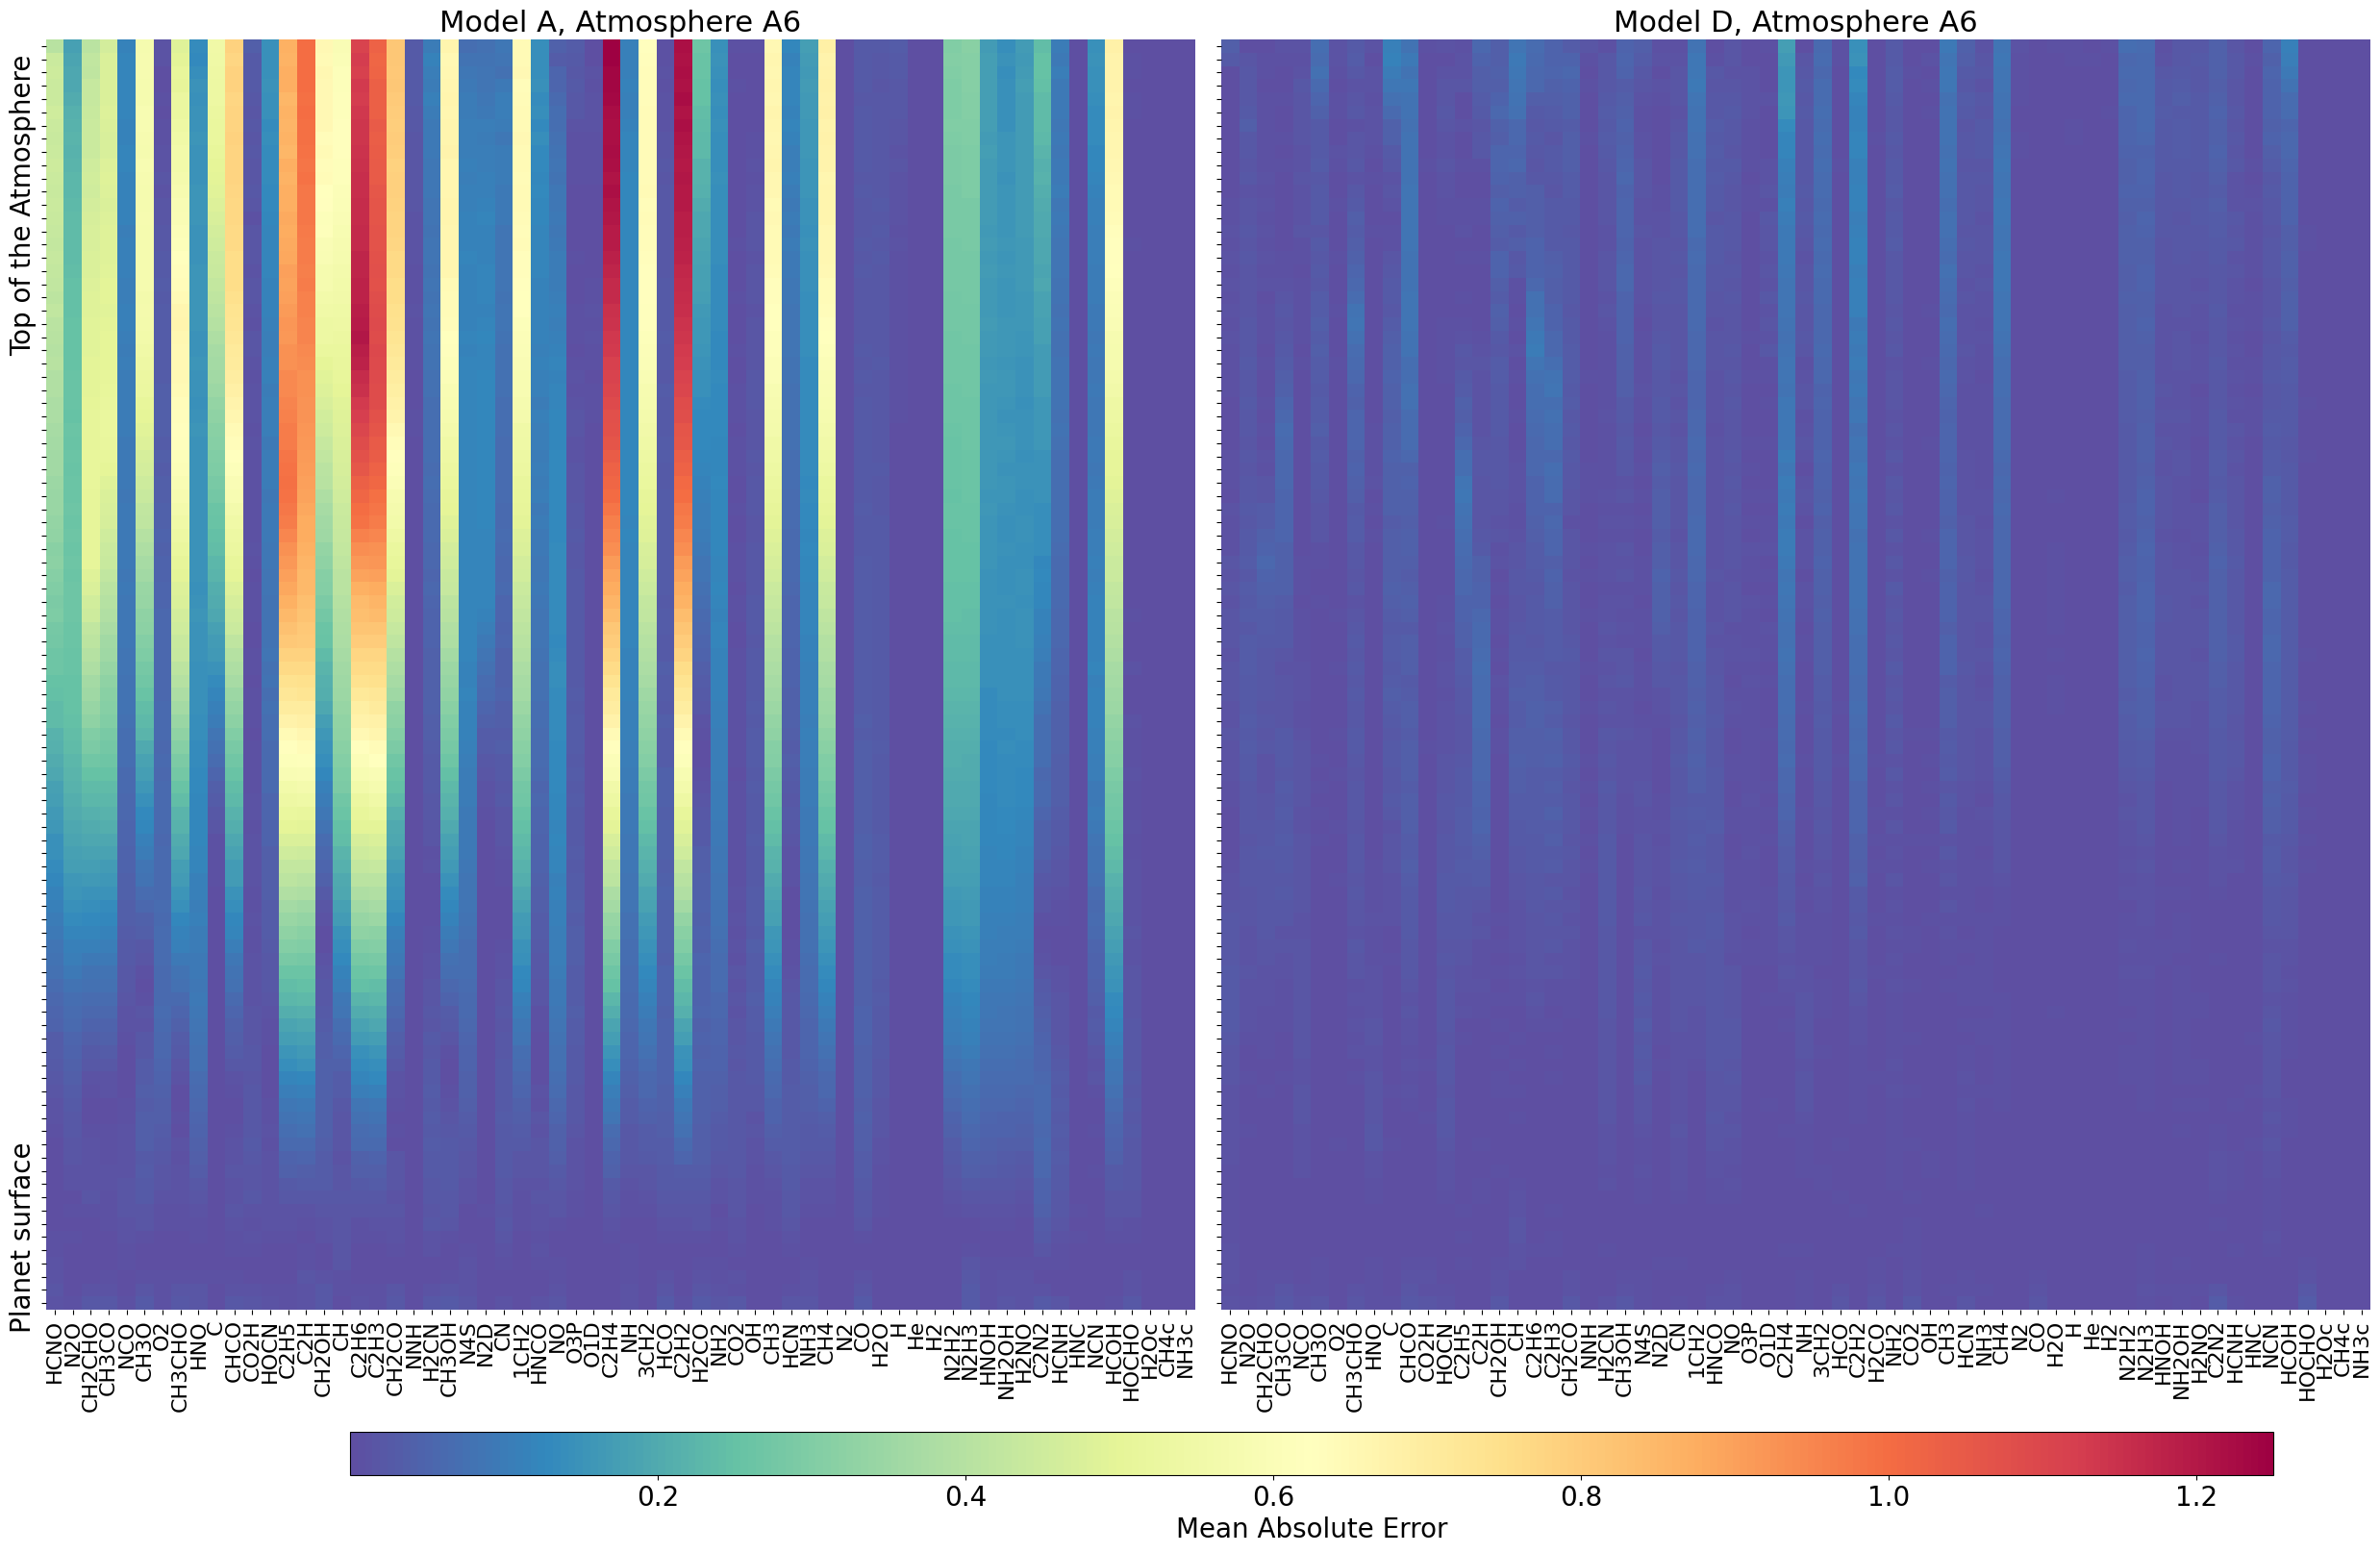

In [38]:
ylabels = [''] * 96  # Create a list of empty strings for each layer.
ylabels[-13] = 'Top of the Atmosphere'  # Set the first element to 'Top of the Atmosphere'.
ylabels[5] = 'Planet surface'

n = 3037
average_importance_simple =np.abs(network_output_modelA[n] - ground_truth[n])
average_importance_bs8 = np.abs(network_output_chexanet[n] - ground_truth[n])
min_val = min(np.min(average_importance_simple), np.min(average_importance_bs8)) # Adjust for your actual data
max_val = max(np.max(average_importance_simple), np.max(average_importance_bs8)) # Adjust for your actual data

fig, axes = plt.subplots(1, 2, figsize=(25, 15), sharey=True)  # Adjust size as needed

# First subplot
sns.heatmap(average_importance_simple.T, cmap='Spectral_r', ax=axes[0],
            xticklabels=molecules, yticklabels=True,
            vmin=min_val, vmax=max_val, cbar=False)
axes[0].set_title(f'Model A, Atmosphere {index_atmosphere_dict[n]}', fontsize=22)
#axes[0].set_xlabel('Molecules')
axes[0].invert_yaxis()  # Invert the y-axis to have 'Planet surface' at the bottom.
axes[0].set_yticklabels(ylabels, fontsize=20)  
axes[0].set_xticklabels(molecules, fontsize=16)  
axes[0].tick_params(axis='x', rotation=90)
axes[0].tick_params(axis='y', rotation=90)
# Second subplot
sns.heatmap(average_importance_bs8.T, cmap='Spectral_r', ax=axes[1],
            xticklabels=molecules,yticklabels=True,
            vmin=min_val, vmax=max_val, cbar=False)
axes[1].set_title(f'Model D, Atmosphere {index_atmosphere_dict[n]}', fontsize=22)
#axes[1].set_xlabel('Molecules')
axes[1].invert_yaxis()  
axes[1].set_yticklabels(ylabels)  
axes[1].set_xticklabels(molecules, fontsize=16)  
axes[1].tick_params(axis='x', rotation=90)
axes[1].tick_params(axis='y', rotation=90)

plt.tight_layout()
cbar_ax = fig.add_axes([0.15, -0.03, 0.8, 0.03])  # [left, bottom, width, height]
sm = plt.cm.ScalarMappable(cmap='Spectral_r', norm=plt.Normalize(vmin=min_val, vmax=max_val))
cbar = fig.colorbar(sm, cax=cbar_ax, orientation='horizontal')
cbar.set_label('Mean Absolute Error', fontsize=20)  # Increase fontsize as needed
# To increase the tick label size
cbar.ax.tick_params(labelsize=20)
# Uncomment the line below to save the figure
plt.savefig(f'MAE_MA_ME_layer_Atmosphere{index_atmosphere_dict[n]}_V2.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
#Figure A1

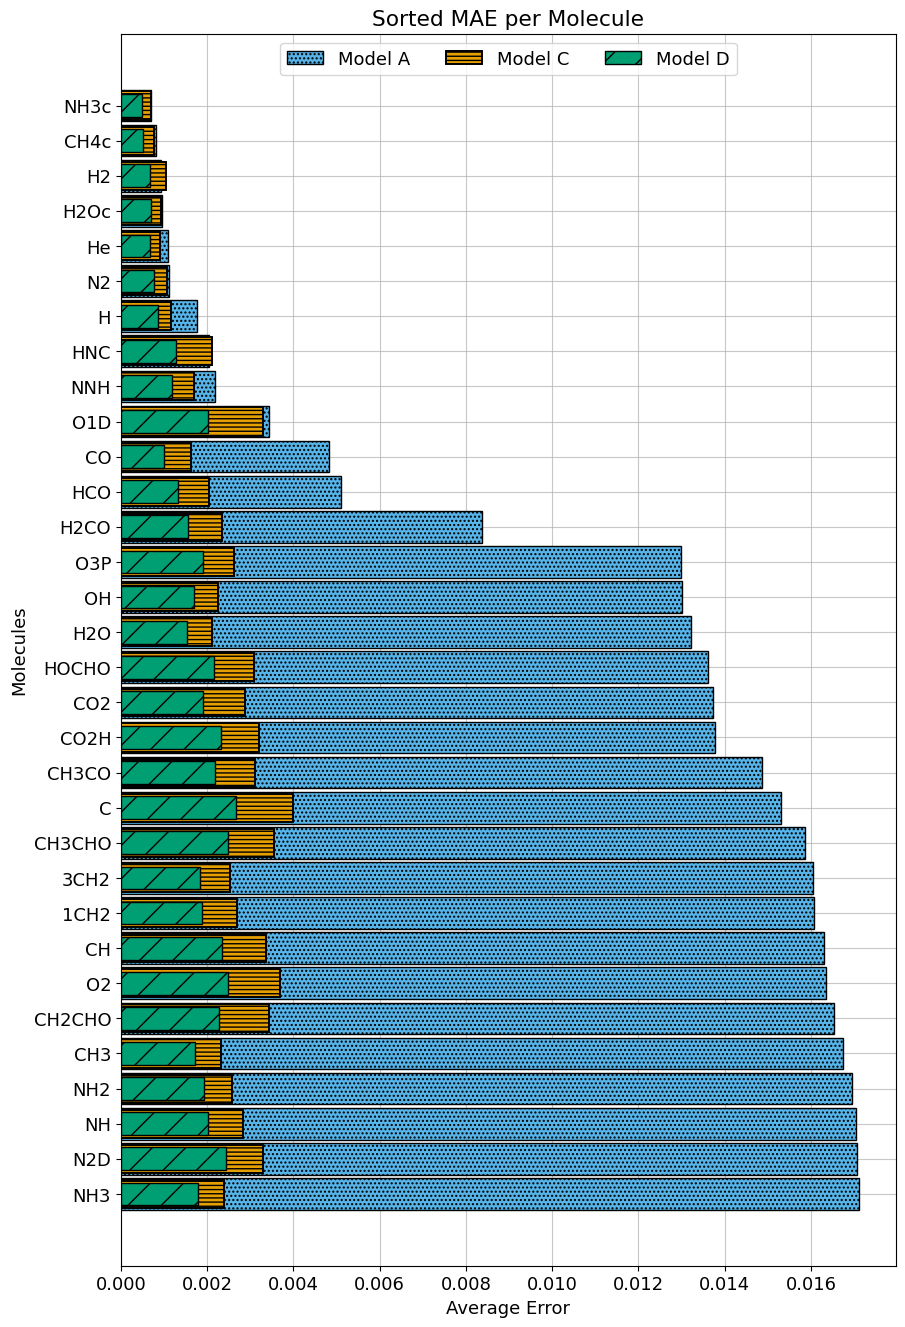

In [45]:
plt.rc('font', size=13)
feature_importance_simple = np.mean(np.abs(network_output_modelA - ground_truth), axis=0).mean(axis=1)
feature_importance_att_addinf = np.mean(np.abs(network_output_modelC - ground_truth), axis=0).mean(axis=1)
feature_importance_dl8 = np.mean(np.abs(network_output_chexanet - ground_truth), axis=0).mean(axis=1)
# Sort feature importance and corresponding molecules
sorted_indices = np.argsort(feature_importance_simple)[::-1]
sorted_importance_simple = feature_importance_simple[sorted_indices]
sorted_importance_att_addinf = feature_importance_att_addinf[sorted_indices]
sorted_importance_dl8 = feature_importance_dl8[sorted_indices]
sorted_molecules = [molecules[i] for i in sorted_indices]
colors = ['#444B70','#8BBBB4', '#EFCB8C']
# Plotting
plt.figure(figsize=(10, len(sorted_molecules)/4))

plt.barh(sorted_molecules[32:], sorted_importance_simple[32:], color ='#56B4E9',label = 'Model A' ,
         height=0.9, edgecolor = 'black', zorder=3, hatch='....')
plt.barh(sorted_molecules[32:], sorted_importance_att_addinf[32:], color = '#E69F00',label = 'Model C',
         height = 0.8, edgecolor = 'black', zorder=3, lw=1.4, hatch='----')
plt.barh(sorted_molecules[32:], sorted_importance_dl8[32:], color ='#009E73', label = 'Model D',
         height = 0.65, edgecolor = 'black', zorder=3, hatch='/', lw=1 )

plt.legend(loc='upper center', bbox_to_anchor=(0.5,1), ncols = 3)
plt.xlabel('Average Error')
plt.ylabel('Molecules')
plt.title('Sorted MAE per Molecule')
plt.grid(alpha=0.7, zorder=0)
plt.savefig('MAE_vs_Molecules_P1_V2.png', dpi=300,bbox_inches='tight')
plt.show()

In [41]:
#Figure A2

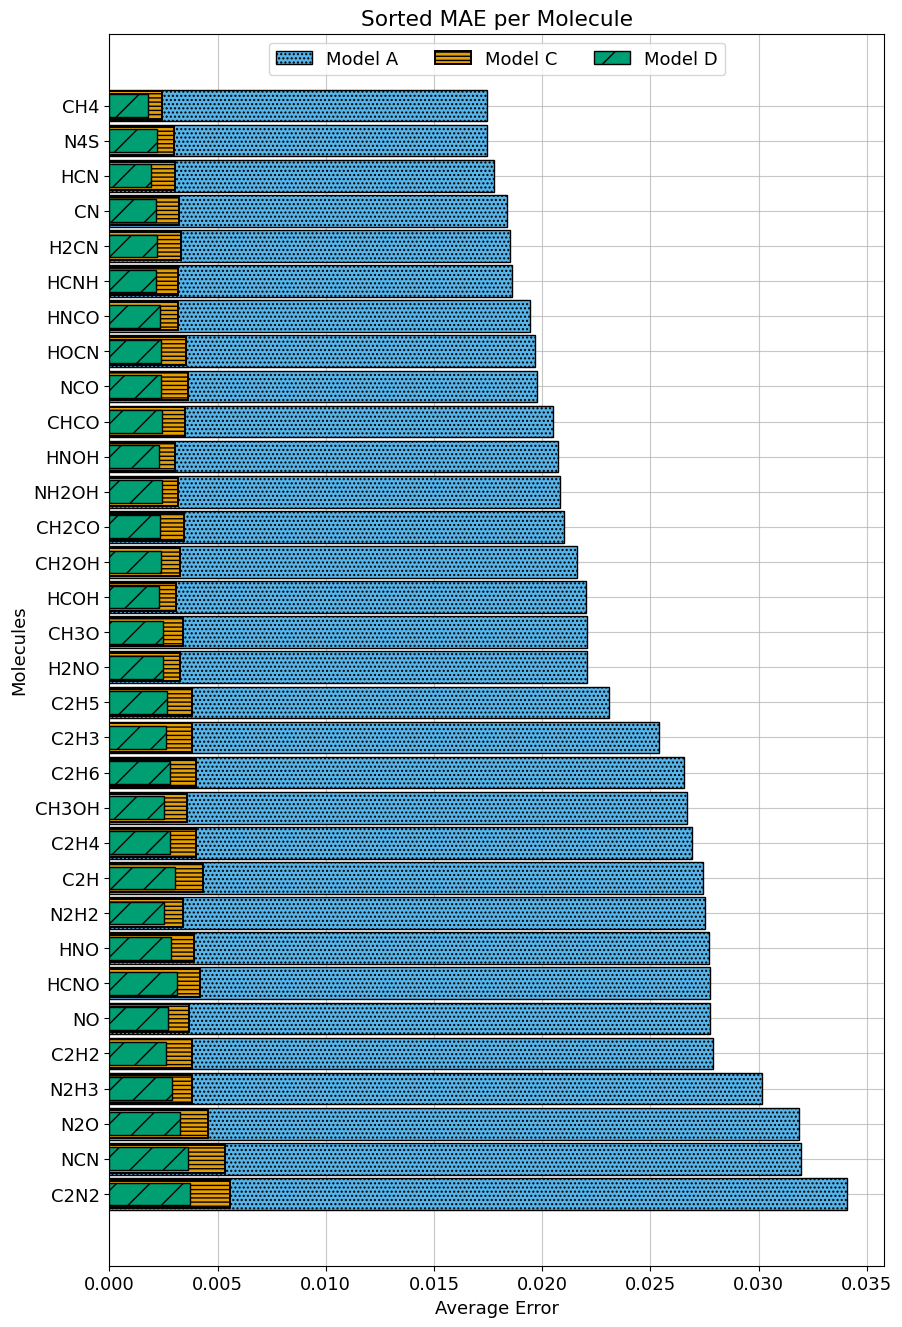

In [46]:
plt.rc('font', size=13)
feature_importance_simple = np.mean(np.abs(network_output_modelA - ground_truth), axis=0).mean(axis=1)
feature_importance_att_addinf = np.mean(np.abs(network_output_modelC - ground_truth), axis=0).mean(axis=1)
feature_importance_dl8 = np.mean(np.abs(network_output_chexanet - ground_truth), axis=0).mean(axis=1)
# Sort feature importance and corresponding molecules
sorted_indices = np.argsort(feature_importance_simple)[::-1]
sorted_importance_simple = feature_importance_simple[sorted_indices]
sorted_importance_att_addinf = feature_importance_att_addinf[sorted_indices]
sorted_importance_dl8 = feature_importance_dl8[sorted_indices]
sorted_molecules = [molecules[i] for i in sorted_indices]
colors = ['#444B70','#8BBBB4', '#EFCB8C']
# Plotting
plt.figure(figsize=(10, len(sorted_molecules)/4))

plt.barh(sorted_molecules[:32], sorted_importance_simple[:32], color ='#56B4E9',label = 'Model A' ,
         height=0.9, edgecolor = 'black', zorder=3, hatch='....')
plt.barh(sorted_molecules[:32], sorted_importance_att_addinf[:32], color = '#E69F00',label = 'Model C',
         height = 0.8, edgecolor = 'black', zorder=3, lw=1.4, hatch='----')
plt.barh(sorted_molecules[:32], sorted_importance_dl8[:32], color ='#009E73', label = 'Model D',
         height = 0.65, edgecolor = 'black', zorder=3, hatch='/', lw=1 )

plt.legend(loc='upper center', bbox_to_anchor=(0.5,1), ncols = 3)
plt.xlabel('Average Error')
plt.ylabel('Molecules')
plt.title('Sorted MAE per Molecule')
plt.grid(alpha=0.7, zorder=0)
plt.savefig('MAE_vs_Molecules_P2_V2.png', dpi=300,bbox_inches='tight')
plt.show()

In [ ]:
#Figure A3

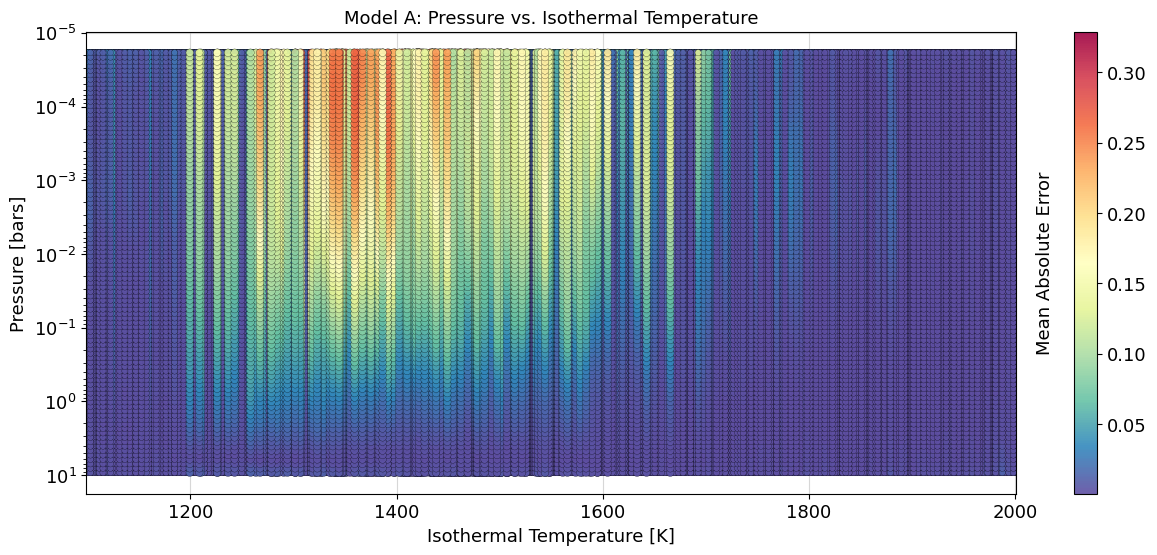

In [51]:
def temperature_vs_pressure(network_output, ground_truth, pascals_values, name=None, save=False):
    plt.rc('font', size=13)
    t = configuration['isothermal_T'].to_numpy()
    temperature_expanded = t[:, np.newaxis]
    temperature_final = np.tile(temperature_expanded, (1, 96))
    bars_values = convert_pascals_to_bars(pascals_values)
    
    fig, ax = plt.subplots(figsize=(15, 6))
    sample_mae = np.mean(np.abs(network_output - ground_truth), axis=1)

    
    high_error_indices = np.mean(sample_mae, axis=1) > 0.0679 

    
    temperature_final_filtered = temperature_final#[high_error_indices]
    expanded_bars_values = np.tile(bars_values, (len(temperature_final_filtered), 1))
    sample_mae_filtered = sample_mae#[high_error_indices]

    # Plot for planet mass
    scatter = ax.scatter(x=temperature_final_filtered, y=expanded_bars_values,
                         c=sample_mae_filtered, alpha=0.9, zorder=2, s=20,
                         edgecolor='black', linewidth=0.2, cmap='Spectral_r')
    expanded_bars_values = np.tile(bars_values, (len(temperature_final_filtered[high_error_indices]), 1))
    
    scatter2 = ax.scatter(x=temperature_final_filtered[high_error_indices], y=expanded_bars_values,
                         c=sample_mae_filtered[high_error_indices], alpha=0.9, zorder=3, s=30,
                         edgecolor='black', linewidth=0.2, cmap='Spectral_r')
    #ax.axhline(y=1, color='black', linestyle='--', linewidth=1.5)
    #ax.axhline(y=2.0417379446695274, color='black', linestyle='--', linewidth=1.5)
    # Creating color bar for planet mass
    ax.set_yscale('log')
    ax.invert_yaxis()
    ax.set_xlim(1099, 2001)
    cbar = plt.colorbar(scatter)
    cbar.set_label('Mean Absolute Error', labelpad=-80)

    ax.set_xlabel('Isothermal Temperature [K]')
    ax.set_ylabel('Pressure [bars]')
    ax.set_title(f'Model {name}: Pressure vs. Isothermal Temperature', fontsize=13)
    plt.grid(alpha=0.5, zorder=0)
    
    
    
    if save:
        plt.savefig(f'Pressure_temperature_{name}_V2.png')
    
    plt.show()
    
temperature_vs_pressure(network_output_modelA, ground_truth, pressure,
                  name='A', save=True)